In [1]:
from __future__ import annotations
from abc        import ABC, abstractmethod
from typing     import List

import sys
sys.path.insert(0, '../../..')

import warnings
warnings.filterwarnings("ignore")
import joblib
import requests
import configparser
import asyncio
from binance.client import Client as BinanceClient
from binance.client import AsyncClient
from binance        import BinanceSocketManager
import pandas as pd
import numpy  as np

from ta import momentum, trend, volatility
from ta import volume as tavolume

import mlfinlab as fml

from cgi import test
from multiprocessing.sharedctypes import Value
from yaml import parse
import glob
import warnings
import requests
import dateutil
import pytz
import traceback
import pandas            as pd
import pandas_ta         as ta
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib.dates  as mdates
import mlfinlab          as fml
from   mlfinlab          import sample_weights
import pyfolio           as pf
from scipy.stats         import norm
from backtesting         import Backtest, Strategy
from backtesting.lib     import crossover

from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = (20,12)

In [2]:
# Helper functions

from pathlib import PurePath, Path
import sys
import time
import warnings
import datetime as dt
import multiprocessing as mp
from datetime import datetime
from collections import OrderedDict as od
import re
import os
import json
import pandas as pd
import numpy as np
from numba import jit
from tqdm import tqdm
import matplotlib.pyplot as plt
import mplfinance as mpf

from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score

warnings.filterwarnings('ignore')


class MultiProcessingFunctions:
	""" This static functions in this class enable multi-processing"""
	def __init__(self):
		pass

	@staticmethod
	def lin_parts(num_atoms, num_threads):
		""" This function partitions a list of atoms in subsets (molecules) of equal size.
		An atom is a set of indivisible set of tasks.
		"""

		# partition of atoms with a single loop
		parts = np.linspace(0, num_atoms, min(num_threads, num_atoms) + 1)
		parts = np.ceil(parts).astype(int)
		return parts

	@staticmethod
	def nested_parts(num_atoms, num_threads, upper_triangle=False):
		""" This function enables parallelization of nested loops.
		"""
		# partition of atoms with an inner loop
		parts = []
		num_threads_ = min(num_threads, num_atoms)

		for num in range(num_threads_):
			part = 1 + 4 * (parts[-1] ** 2 + parts[-1] + num_atoms * (num_atoms + 1.) / num_threads_)
			part = (-1 + part ** .5) / 2.
			parts.append(part)

		parts = np.round(parts).astype(int)

		if upper_triangle:  # the first rows are heaviest
			parts = np.cumsum(np.diff(parts)[::-1])
			parts = np.append(np.array([0]), parts)
		return parts

	@staticmethod
	def mp_pandas_obj(func, pd_obj, num_threads=24, mp_batches=1, lin_mols=True, **kargs):
		"""	
		:param func: (string) function to be parallelized
		:param pd_obj: (vector) Element 0, is name of argument used to pass the molecule;
						Element 1, is the list of atoms to be grouped into a molecule
		:param num_threads: (int) number of threads
		:param mp_batches: (int) number of batches
		:param lin_mols: (bool) Tells if the method should use linear or nested partitioning
		:param kargs: (var args)
		:return: (data frame) of results
		"""

		if lin_mols:
			parts = MultiProcessingFunctions.lin_parts(len(pd_obj[1]), num_threads * mp_batches)
		else:
			parts = MultiProcessingFunctions.nested_parts(len(pd_obj[1]), num_threads * mp_batches)

		jobs = []
		for i in range(1, len(parts)):
			job = {pd_obj[0]: pd_obj[1][parts[i - 1]:parts[i]], 'func': func}
			job.update(kargs)
			jobs.append(job)

		if num_threads == 1:
			out = MultiProcessingFunctions.process_jobs_(jobs)
		else:
			out = MultiProcessingFunctions.process_jobs(jobs, num_threads=num_threads)

		if isinstance(out[0], pd.DataFrame):
			df0 = pd.DataFrame()
		elif isinstance(out[0], pd.Series):
			df0 = pd.Series()
		else:
			return out

		for i in out:
			df0 = df0.append(i)

		df0 = df0.sort_index()
		return df0

	@staticmethod
	def process_jobs_(jobs):
		""" Run jobs sequentially, for debugging """
		out = []
		for job in jobs:
			out_ = MultiProcessingFunctions.expand_call(job)
			out.append(out_)
		return out

	@staticmethod
	def expand_call(kargs):
		""" Expand the arguments of a callback function, kargs['func'] """
		func = kargs['func']
		del kargs['func']
		out = func(**kargs)
		return out

	@staticmethod
	def report_progress(job_num, num_jobs, time0, task):
		# Report progress as asynch jobs are completed

		msg = [float(job_num) / num_jobs, (time.time() - time0)/60.]
		msg.append(msg[1] * (1/msg[0] - 1))
		time_stamp = str(dt.datetime.fromtimestamp(time.time()))

		msg = time_stamp + ' ' + str(round(msg[0]*100, 2)) + '% '+task+' done after ' + \
			str(round(msg[1], 2)) + ' minutes. Remaining ' + str(round(msg[2], 2)) + ' minutes.'

		if job_num < num_jobs:
			sys.stderr.write(msg+'\r')
		else:
			sys.stderr.write(msg+'\n')

		return

	@staticmethod
	def process_jobs(jobs, task=None, num_threads=24):
		""" Run in parallel. jobs must contain a 'func' callback, for expand_call"""

		if task is None:
			task = jobs[0]['func'].__name__

		pool = mp.Pool(processes=num_threads)
		# outputs, out, time0 = pool.imap_unordered(MultiProcessingFunctions.expand_call,jobs),[],time.time()
		outputs = pool.imap_unordered(MultiProcessingFunctions.expand_call, jobs)
		out = []
		time0 = time.time()

		# Process asyn output, report progress
		for i, out_ in enumerate(outputs, 1):
			out.append(out_)
			MultiProcessingFunctions.report_progress(i, len(jobs), time0, task)

		pool.close()
		pool.join()  # this is needed to prevent memory leaks
		return out


def get_daily_vol(close, lookback=100):
    """
    :param close: (data frame) Closing prices
    :param lookback: (int) lookback period to compute volatility
    :return: (series) of daily volatility value
    """
    print('Calculating daily volatility for dynamic thresholds')
    
    df0 = close.index.searchsorted(close.index - pd.Timedelta(days=1))
    df0 = df0[df0 > 0]
    df0 = (pd.Series(close.index[df0 - 1], index=close.index[close.shape[0] - df0.shape[0]:]))
        
    df0 = close.loc[df0.index] / close.loc[df0.values].values - 1  # daily returns
    df0 = df0.ewm(span=lookback).std()
    return df0


def get_t_events(raw_price, threshold):
    """
    :param raw_price: (series) of close prices.
    :param threshold: (float) when the abs(change) is larger than the threshold, the
    function captures it as an event.
    :return: (datetime index vector) vector of datetimes when the events occurred. This is used later to sample.
    """
    print('Applying Symmetric CUSUM filter.')

    t_events = []
    s_pos = 0
    s_neg = 0

    # log returns
    diff = np.log(raw_price).diff().dropna()

    # Get event time stamps for the entire series
    for i in tqdm(diff.index[1:]):
        pos = float(s_pos + diff.loc[i])
        neg = float(s_neg + diff.loc[i])
        s_pos = max(0.0, pos)
        s_neg = min(0.0, neg)

        if s_neg < -threshold:
            s_neg = 0
            t_events.append(i)

        elif s_pos > threshold:
            s_pos = 0
            t_events.append(i)

    event_timestamps = pd.DatetimeIndex(t_events)
    return event_timestamps


def add_vertical_barrier(t_events, close, num_days=1):
    """
    :param t_events: (series) series of events (symmetric CUSUM filter)
    :param close: (series) close prices
    :param num_days: (int) maximum number of days a trade can be active
    :return: (series) timestamps of vertical barriers
    """
    t1 = close.index.searchsorted(t_events + pd.Timedelta(days=num_days))
    t1 = t1[t1 < close.shape[0]]
    t1 = pd.Series(close.index[t1], index=t_events[:t1.shape[0]])  # NaNs at end
    return t1


def apply_pt_sl_on_t1(close, events, pt_sl, molecule):
    """
    :param close: (series) close prices
    :param events: (series) of indices that signify "events" 
    :param pt_sl: (array) element 0, indicates the profit taking level; 
                          element 1 is stop loss level
    :param molecule: (an array) a set of datetime index values for processing
    :return: (dataframe) timestamps at which each barrier was touched
    """
    # apply stop loss/profit taking, if it takes place before t1 (end of event)
    events_ = events.loc[molecule]
    out = events_[['t1']].copy(deep=True)
    if pt_sl[0] > 0:
        pt = pt_sl[0] * events_['trgt']
    else:
        pt = pd.Series(index=events.index)  # NaNs

    if pt_sl[1] > 0:
        sl = -pt_sl[1] * events_['trgt']
    else:
        sl = pd.Series(index=events.index)  # NaNs

    for loc, t1 in events_['t1'].fillna(close.index[-1]).iteritems():
        df0 = close[loc:t1]  # path prices
        df0 = (df0 / close[loc] - 1) * events_.at[loc, 'side']  # path returns
        out.loc[loc, 'sl'] = df0[df0 < sl[loc]].index.min()  # earliest stop loss
        out.loc[loc, 'pt'] = df0[df0 > pt[loc]].index.min()  # earliest profit taking

    return out


def get_events(close, t_events, pt_sl, target, min_ret, num_threads, 
              vertical_barrier_times=False, side=None):
    """
    :param close: (series) Close prices
    :param t_events: (series) of t_events. 
                     These are timestamps that will seed every triple barrier.
    :param pt_sl: (2 element array) element 0, indicates the profit taking level; 
                  element 1 is stop loss level.
                  A non-negative float that sets the width of the two barriers. 
                  A 0 value means that the respective horizontal barrier will be disabled.
    :param target: (series) of values that are used (in conjunction with pt_sl)
                   to determine the width of the barrier.
    :param min_ret: (float) The minimum target return required for running a triple barrier search.
    :param num_threads: (int) The number of threads concurrently used by the function.
    :param vertical_barrier_times: (series) A pandas series with the timestamps of the vertical barriers.
    :param side: (series) Side of the bet (long/short) as decided by the primary model
    :return: (data frame) of events
            -events.index is event's starttime
            -events['t1'] is event's endtime
            -events['trgt'] is event's target
            -events['side'] (optional) implies the algo's position side
    """

    # 1) Get target
    target = target.loc[target.index.intersection(t_events)]
    target = target[target > min_ret]  # min_ret

    # 2) Get vertical barrier (max holding period)
    if vertical_barrier_times is False:
        vertical_barrier_times = pd.Series(pd.NaT, index=t_events)

    # 3) Form events object, apply stop loss on vertical barrier
    if side is None:
        side_ = pd.Series(1., index=target.index)
        pt_sl_ = [pt_sl[0], pt_sl[0]]
    else:
        side_ = side.loc[target.index]
        pt_sl_ = pt_sl[:2]

    events = pd.concat({'t1': vertical_barrier_times, 'trgt': target, 'side': side_},
                        axis=1)
    events = events.dropna(subset=['trgt'])

    # Apply Triple Barrier
    df0 = MultiProcessingFunctions.mp_pandas_obj(func=apply_pt_sl_on_t1,
                                                 pd_obj=('molecule', events.index),
                                                 num_threads=num_threads,
                                                 close=close,
                                                 events=events,
                                                 pt_sl=pt_sl_)

    events['t1'] = df0.dropna(how='all').min(axis=1)  # pd.min ignores nan

    if side is None:
        events = events.drop('side', axis=1)

    return events


def barrier_touched(out_df):
    """
    :param out_df: (DataFrame) containing the returns and target
    :return: (DataFrame) containing returns, target, and labels
    """
    store = []
    for i in np.arange(len(out_df)):
        date_time = out_df.index[i]
        ret       = out_df.loc[date_time, 'ret' ]
        target    = out_df.loc[date_time, 'trgt']

        if ret > 0.0 and ret > target:
            # Top barrier reached
            store.append(1)
        elif ret < 0.0 and ret < -target:
            # Bottom barrier reached
            store.append(-1)
        else:
            # Vertical barrier reached
            store.append(0)

    out_df['bin'] = store

    return out_df


def get_bins(triple_barrier_events, close):
    """
    :param triple_barrier_events: (data frame)
                -events.index is event's starttime
                -events['t1'] is event's endtime
                -events['trgt'] is event's target
                -events['side'] (optional) implies the algo's position side
                Case 1: ('side' not in events): bin in (-1,1) <-label by price action
                Case 2: ('side' in events): bin in (0,1) <-label by pnl (meta-labeling)
    :param close: (series) close prices
    :return: (data frame) of meta-labeled events
    """

    # 1) Align prices with their respective events
    events_ = triple_barrier_events.dropna(subset=['t1'])
    prices = events_.index.union(events_['t1'].values)
    prices = prices.drop_duplicates()
    prices = close.reindex(prices, method='bfill')
    
    # 2) Create out DataFrame
    out_df = pd.DataFrame(index=events_.index)
    # Need to take the log returns, else your results will be skewed for short positions
    out_df['ret' ] = np.log(prices.loc[events_['t1'].values].values) - np.log(prices.loc[events_.index])
    out_df['trgt'] = events_['trgt']

    # Meta labeling: Events that were correct will have pos returns
    if 'side' in events_:
        out_df['ret'] = out_df['ret'] * events_['side']  # meta-labeling

    # Added code: label 0 when vertical barrier reached
    out_df = barrier_touched(out_df)

    # Meta labeling: label incorrect events with a 0
    if 'side' in events_:
        out_df.loc[out_df['ret'] <= 0, 'bin'] = 0
    
    # Transform the log returns back to normal returns.
    out_df['ret'] = np.exp(out_df['ret']) - 1
    
    # Add the side to the output. This is useful for when a meta label model must be fit
    tb_cols = triple_barrier_events.columns
    if 'side' in tb_cols:
        out_df['side'] = triple_barrier_events['side']
        
    out_df

    return out_df


def get_daily_volatility(close, lookback=100):
    # daily vol re-indexed to close
    df0 = close.index.searchsorted(close.index - pd.Timedelta(days=1))
    df0 = df0[df0 > 0]
    df0 = (pd.Series(close.index[df0 - 1], index=close.index[close.shape[0] - df0.shape[0]:]))
    df0 = close.loc[df0.index] / close.loc[df0.array].array - 1  # daily returns
    df0 = df0.ewm(span=lookback).std()
    return df0

def cci_indicator(df_, length=40):
    hlc3 = (df_['High']+df_['Low']+df_['Close'])/3
    sma  = hlc3.rolling(length).mean()
    mad  = hlc3.rolling(length).apply(lambda x: pd.Series(x).mad())
    cci  = (hlc3-sma)/(0.015*mad)
    cci_smooth = cci.ewm(span=5, min_periods=0, adjust=False, ignore_na=False).mean()
    return cci, cci_smooth

In [3]:
side_features = []
meta_features = []

with open("../model/features_side.txt", "r") as f:
    side_features = f.readlines()[0].strip().split()
with open("../model/features_meta.txt", "r") as f:
    meta_features = f.readlines()[0].strip().split()

print(f"side features : {side_features}")
print(f"meta features : {meta_features}")

side_rf = joblib.load("../model/btcusdt_rf_side.save")
meta_rf = joblib.load("../model/btcusdt_rf_meta.save")

print(side_rf)
print(meta_rf)

side features : ['ma_440', 'daily_volatility_30', 'vm_eom_25', 'vl_atr_180', 'vm_cmf_180']
meta features : ['vl_bbp', 't_adx_90', 'close_plus_minus_40']
RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=30, n_estimators=512, n_jobs=-1,
                       random_state=42)
RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=30, n_estimators=512, n_jobs=-1,
                       random_state=42)


In [4]:
df = pd.read_csv("../../../data/BTCUSDT-1m-spot-metaml-features.csv", parse_dates=True, index_col="timestamp")

df

,Open,High,Low,Close,Volume,volatility_tpsl_600,volatility_tpsl_840,sma_440,ma_440,daily_volatility_30,vm_eom_25,vl_atr_180,vm_cmf_180,vl_bbp,t_adx_90,momentum_1,close_sign,close_plus_minus_40
timestamp,,,,,,,,,,,,,,,,,,
2017-08-17 04:00:00,4261.48,4261.48,4261.48,4261.48,1.775183,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2017-08-17 04:01:00,4261.48,4261.48,4261.48,4261.48,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2017-08-17 04:02:00,4280.56,4280.56,4280.56,4280.56,0.261074,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.004477,1.0,0.0
2017-08-17 04:03:00,4261.48,4261.48,4261.48,4261.48,0.012008,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000e+00,0.000000,0.000000,0.000000,0.000000,-0.004457,-1.0,0.0
2017-08-17 04:04:00,4261.48,4261.48,4261.48,4261.48,0.140796,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 23:55:00,16540.42,16540.92,16537.71,16539.28,36.236830,0.003830,0.003930,16564.839750,-0.001543,0.000443,1.815970e+06,5.777728,0.025433,0.272406,14.161816,-0.000069,-1.0,4.0
2022-12-31 23:56:00,16538.65,16540.53,16538.38,16540.52,38.588400,0.003830,0.003931,16564.709841,-0.001460,0.000430,7.800272e+05,5.757574,0.026151,0.351183,14.078037,0.000075,1.0,4.0
2022-12-31 23:57:00,16540.52,16540.79,16535.05,16537.78,53.359780,0.003831,0.003932,16564.573614,-0.001618,0.000417,-1.651225e+07,5.757476,0.028138,0.223332,14.009032,-0.000166,-1.0,2.0


In [5]:
volatility_scaler = 0.6
holding_period    = 2.0
cusum_events      = get_t_events(df['Close'], threshold=df['volatility_tpsl_600'].mean()*float(volatility_scaler))
vertical_barriers = add_vertical_barrier(t_events=cusum_events, close=df['Close'], num_days=float(holding_period))

Applying Symmetric CUSUM filter.


100%|██████████| 2817997/2817997 [01:55<00:00, 24321.94it/s]


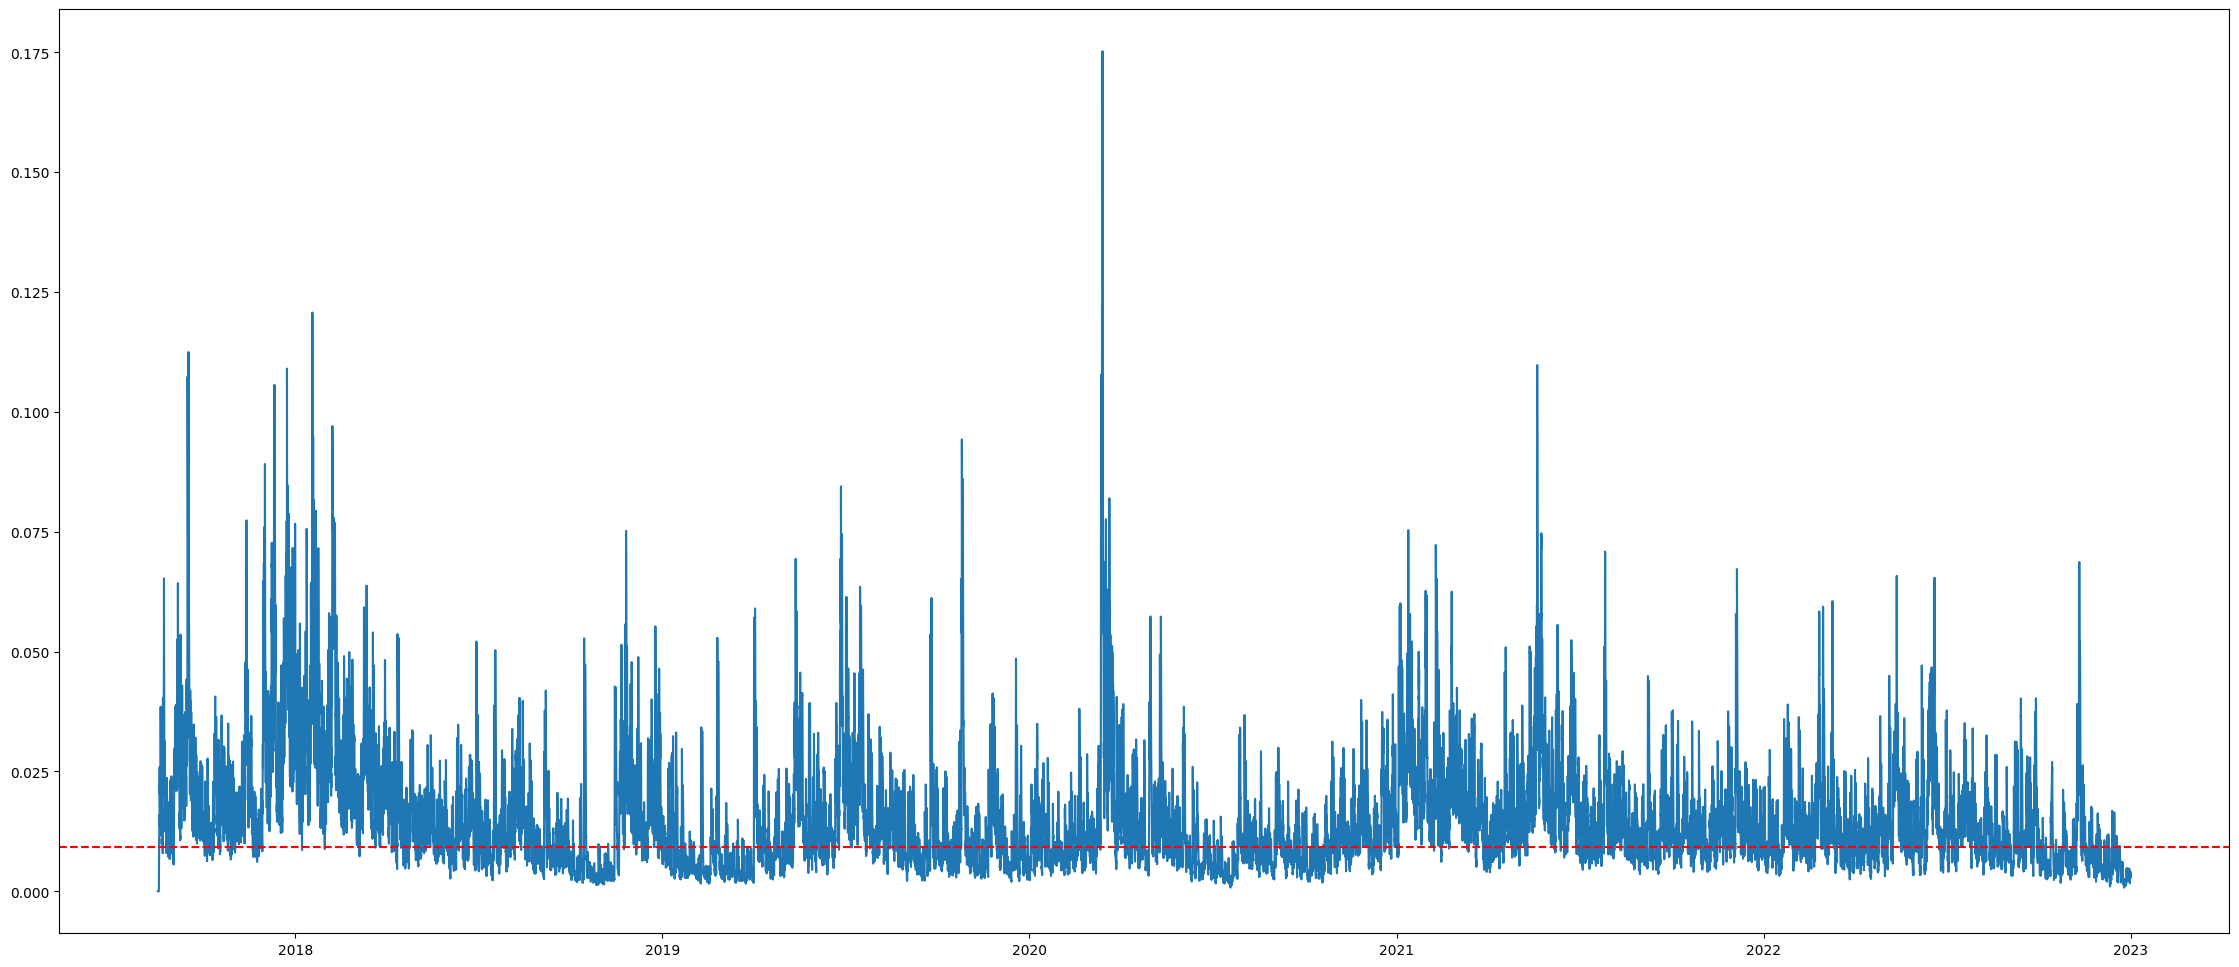

In [6]:
f, axs=plt.subplots(1, figsize=(28,12))
axs.plot(df['volatility_tpsl_600'])
axs.axhline(df['volatility_tpsl_600'].mean()*volatility_scaler, ls='--', color='r')

In [7]:
cusum_events

DatetimeIndex(['2017-08-17 04:43:00', '2017-08-17 06:35:00',
               '2017-08-17 07:29:00', '2017-08-17 07:53:00',
               '2017-08-17 08:05:00', '2017-08-17 09:32:00',
               '2017-08-17 10:06:00', '2017-08-17 10:20:00',
               '2017-08-17 10:35:00', '2017-08-17 10:48:00',
               ...
               '2022-12-27 00:01:00', '2022-12-27 12:56:00',
               '2022-12-27 17:43:00', '2022-12-28 14:48:00',
               '2022-12-28 15:37:00', '2022-12-28 21:25:00',
               '2022-12-29 13:28:00', '2022-12-30 07:24:00',
               '2022-12-30 15:37:00', '2022-12-31 22:50:00'],
              dtype='datetime64[ns]', length=53594, freq=None)

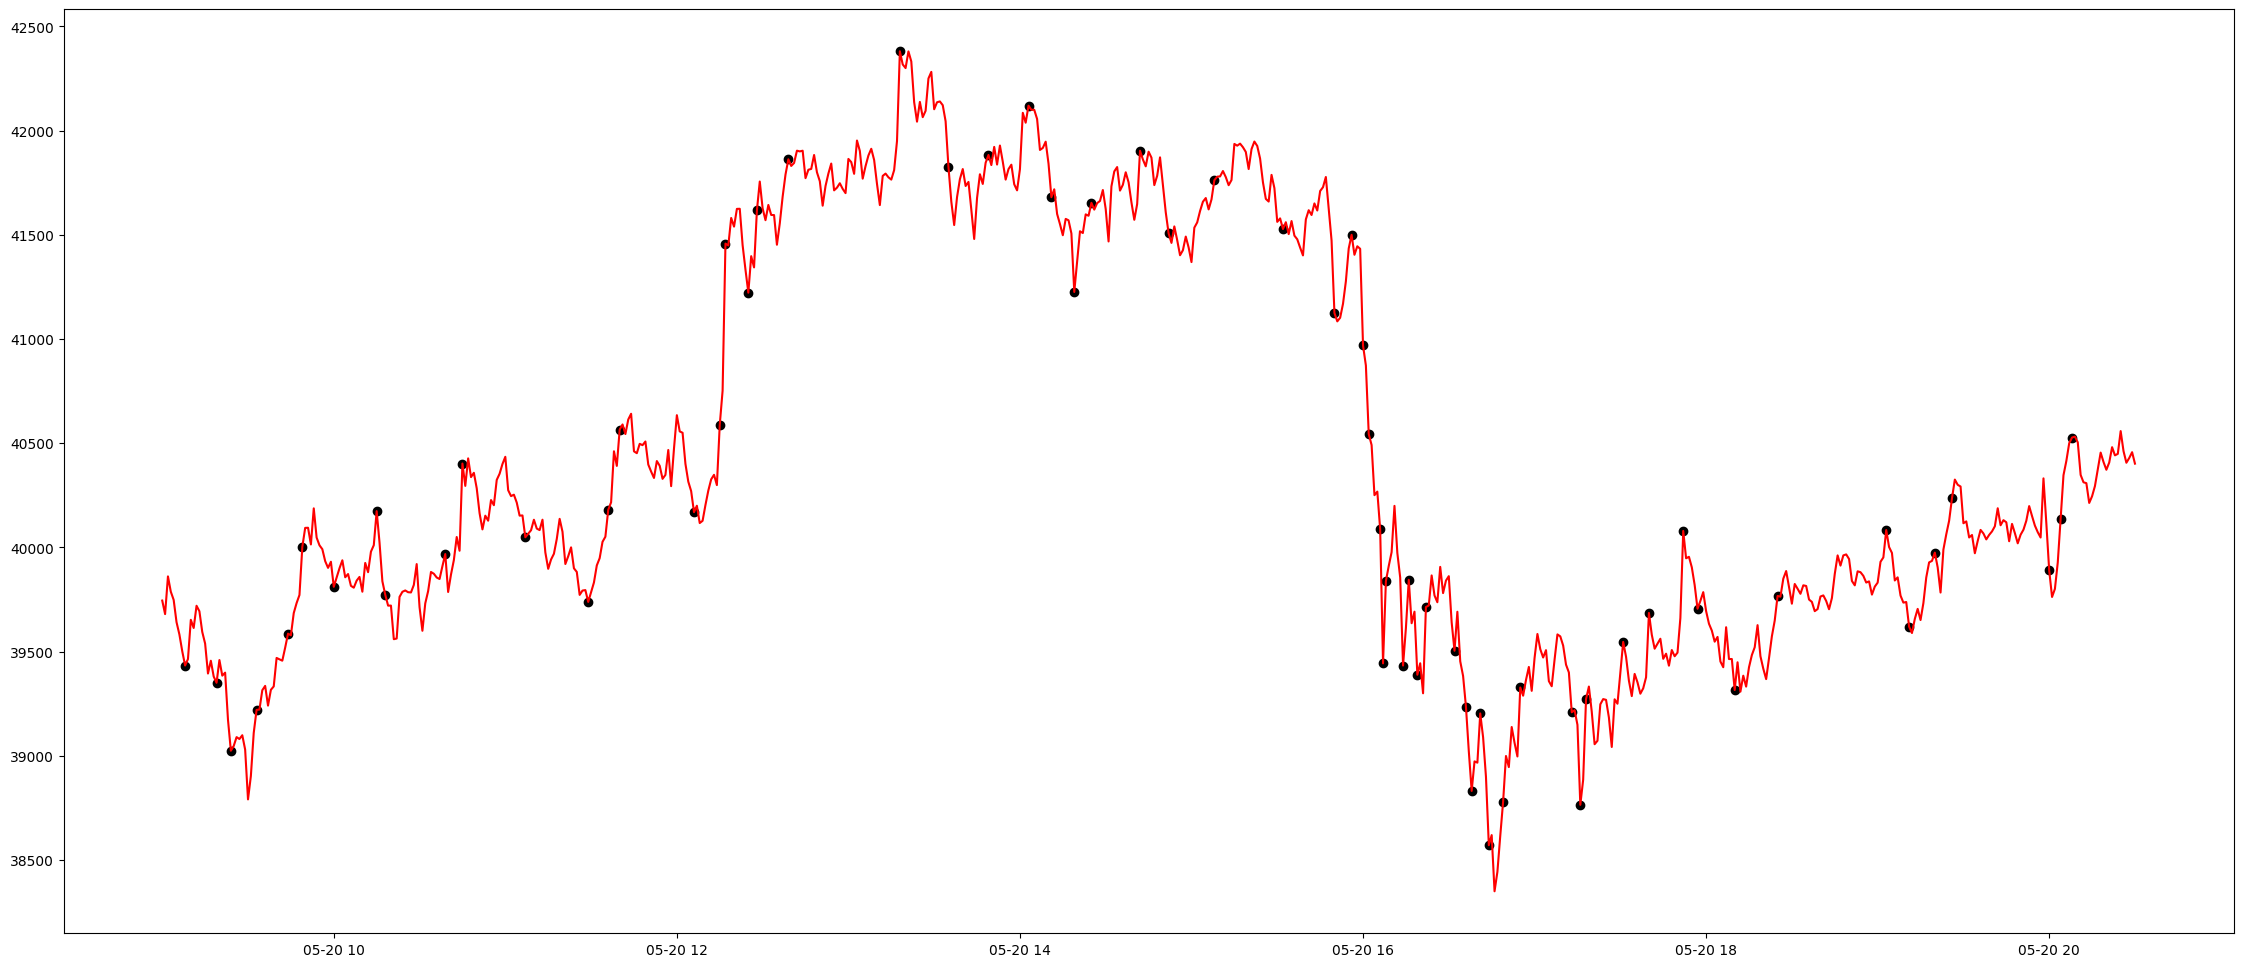

In [8]:
_, axs = plt.subplots(1, figsize=(28, 12))

closing   = df['Close']
startdate = pd.to_datetime("2021-05-20 09:00:00")
enddate   = pd.to_datetime("2021-05-20 20:30:00")
axs.plot(closing.loc[(closing.index>=startdate)&(closing.index<=enddate)], color='r')
closing_ = closing[cusum_events]
closing_ = closing_.loc[(closing_.index>=startdate)&(closing_.index<=enddate)]
axs.scatter(closing_.index, closing_, color='k')

In [9]:
dataset_df = df.loc[cusum_events][side_features].copy()
dataset_df

,ma_440,daily_volatility_30,vm_eom_25,vl_atr_180,vm_cmf_180
2017-08-17 04:43:00,0.000000,0.000000,4.791434e+09,0.000000,0.000000
2017-08-17 06:35:00,0.000000,0.000000,9.624463e+10,0.000000,0.000000
2017-08-17 07:29:00,0.000000,0.000000,-0.000000e+00,2.782545,0.130696
2017-08-17 07:53:00,0.000000,0.000000,0.000000e+00,2.780713,0.104880
2017-08-17 08:05:00,0.000000,0.000000,0.000000e+00,3.361718,0.288457
...,...,...,...,...,...
2022-12-28 21:25:00,-0.008860,0.001618,-2.994633e+08,7.778049,-0.146544
2022-12-29 13:28:00,0.003368,0.000649,1.661669e+07,5.763813,-0.006803
2022-12-30 07:24:00,-0.007089,0.000852,-1.089325e+08,5.688784,-0.071550
2022-12-30 15:37:00,0.003387,0.002713,8.160086e+07,9.230215,-0.029333


In [10]:
dataset_df['side'] = side_rf.predict(dataset_df[side_features])
dataset_df['side'].value_counts()

 1.0    28477
-1.0    25117
Name: side, dtype: int64

In [11]:
dataset_df.loc[dataset_df['side']==-1, 'prob'] = side_rf.predict_proba(dataset_df[dataset_df['side']==-1][side_features])[:,0]
dataset_df.loc[dataset_df['side']== 1, 'prob'] = side_rf.predict_proba(dataset_df[dataset_df['side']== 1][side_features])[:,1]

<AxesSubplot: >

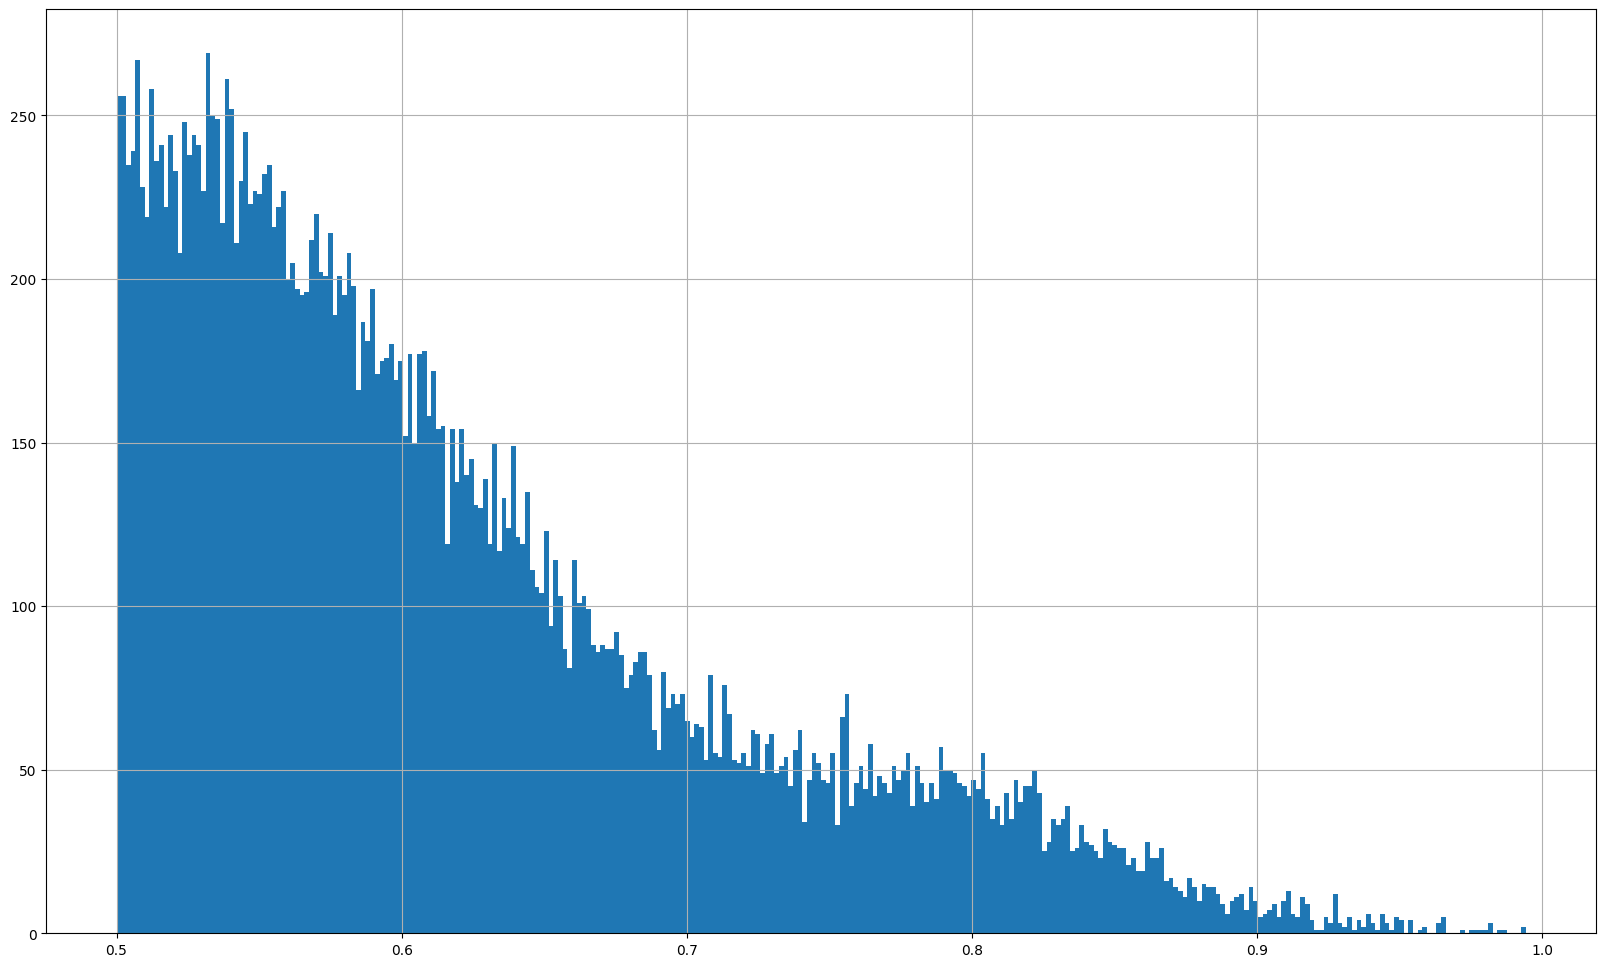

In [12]:
dataset_df[dataset_df['side']==-1]['prob'].hist(bins=300)

<AxesSubplot: >

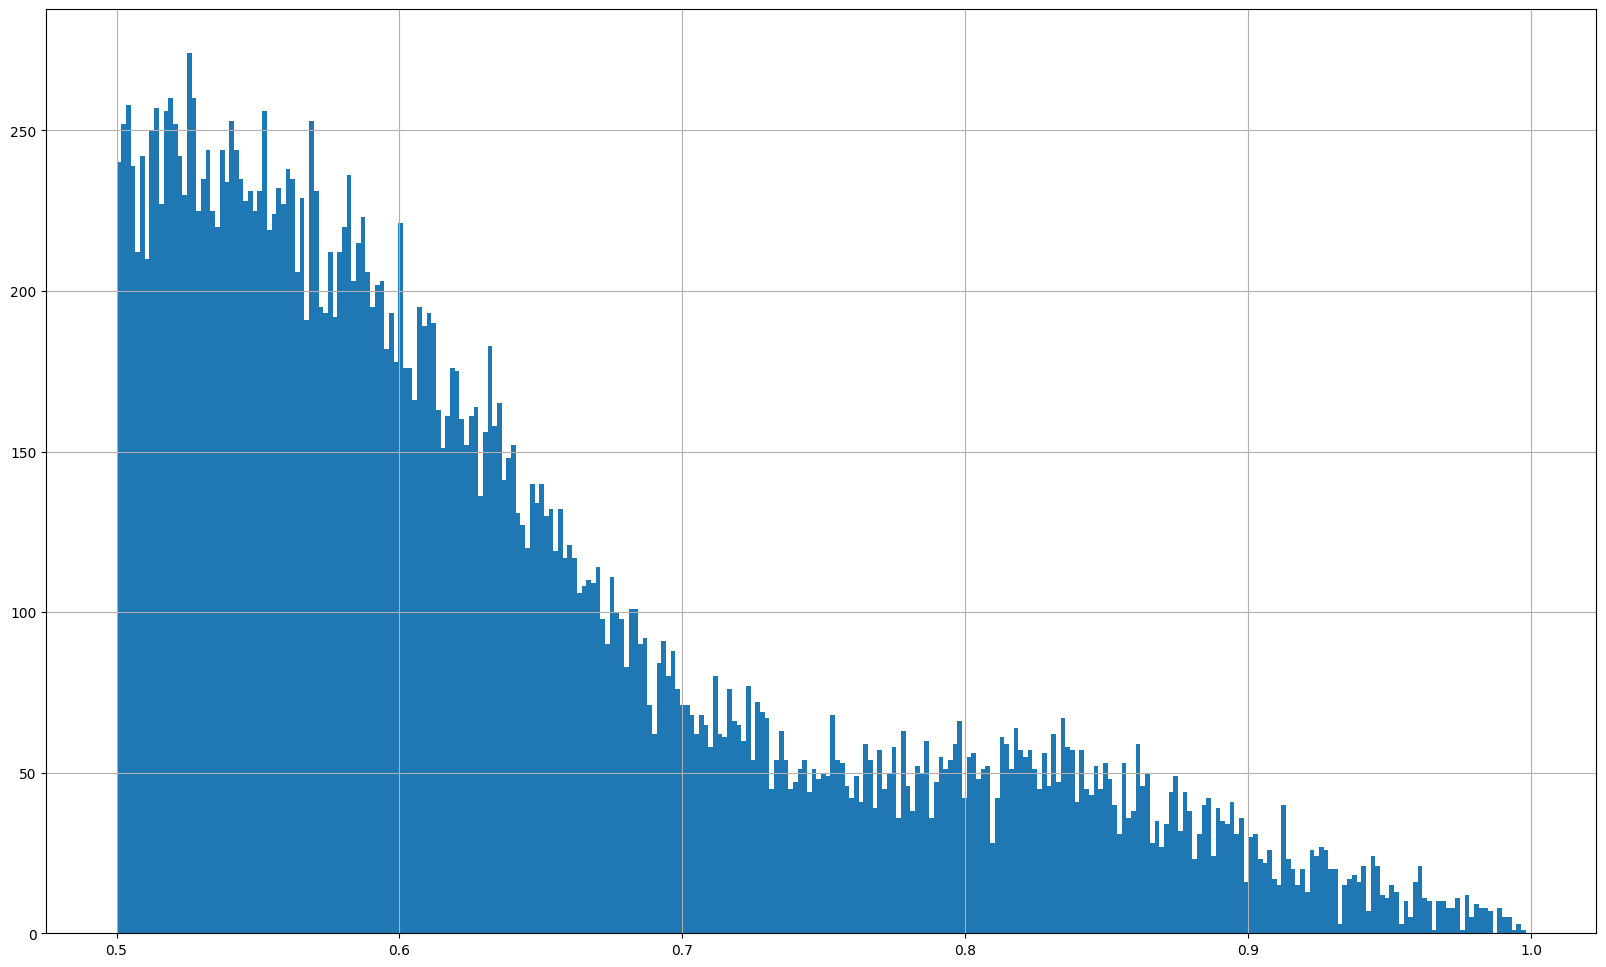

In [13]:
dataset_df[dataset_df['side']== 1]['prob'].hist(bins=300)

In [14]:
prob_threshold   = 0.65
predicted_events = dataset_df[dataset_df['prob']>=prob_threshold].index

predicted_events

DatetimeIndex(['2017-08-17 11:25:00', '2017-08-18 05:30:00',
               '2017-08-18 10:13:00', '2017-08-18 10:50:00',
               '2017-08-18 12:41:00', '2017-08-18 12:45:00',
               '2017-08-18 12:47:00', '2017-08-18 13:25:00',
               '2017-08-18 13:44:00', '2017-08-18 14:33:00',
               ...
               '2022-12-14 18:14:00', '2022-12-14 18:58:00',
               '2022-12-14 19:33:00', '2022-12-15 15:30:00',
               '2022-12-16 07:03:00', '2022-12-16 09:00:00',
               '2022-12-20 00:24:00', '2022-12-28 14:48:00',
               '2022-12-28 15:37:00', '2022-12-28 21:25:00'],
              dtype='datetime64[ns]', length=17493, freq=None)

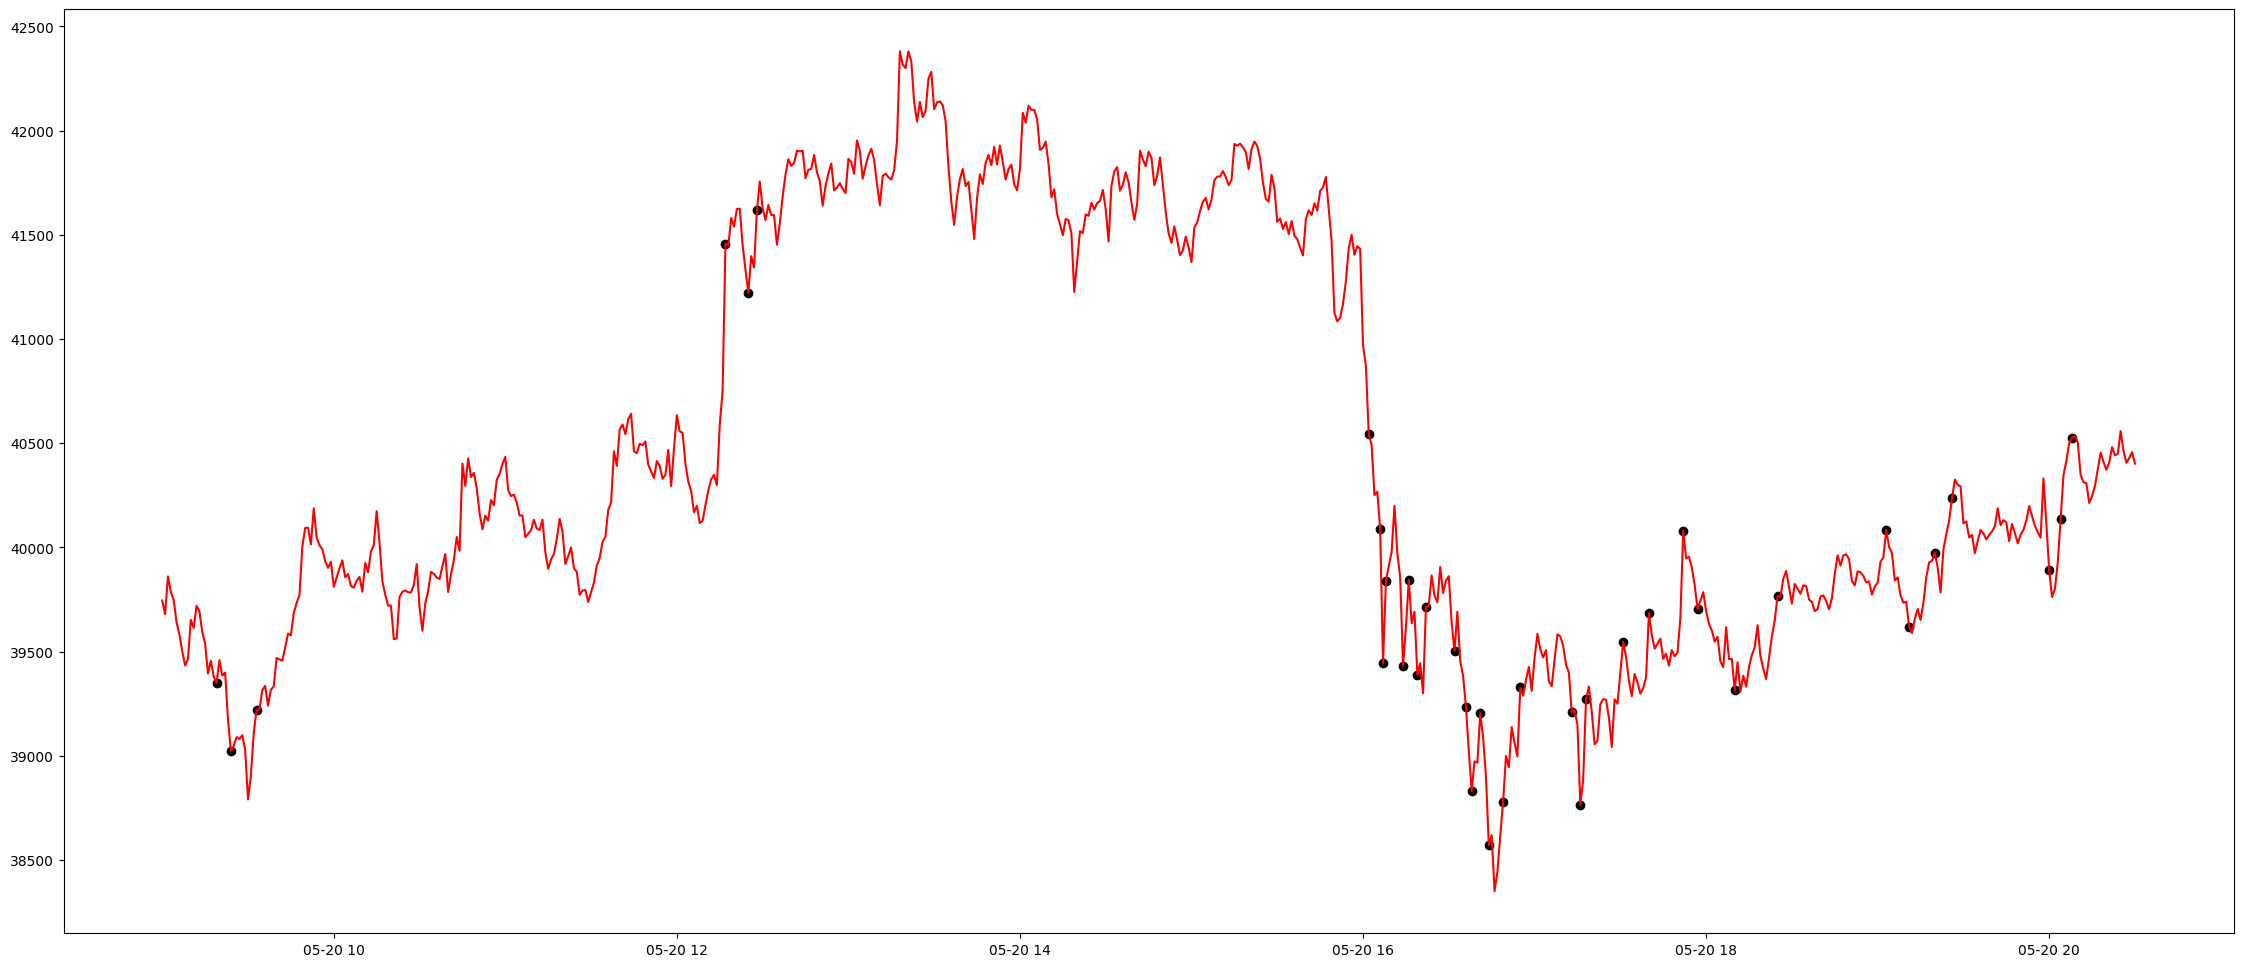

In [15]:
_, axs = plt.subplots(1, figsize=(28, 12))

closing   = df['Close']
startdate = pd.to_datetime("2021-05-20 09:00:00")
enddate   = pd.to_datetime("2021-05-20 20:30:00")
axs.plot(closing.loc[(closing.index>=startdate)&(closing.index<=enddate)], color='r')
closing_ = closing[predicted_events]
closing_ = closing_.loc[(closing_.index>=startdate)&(closing_.index<=enddate)]
axs.scatter(closing_.index, closing_, color='k')

In [16]:
dataset_df

,ma_440,daily_volatility_30,vm_eom_25,vl_atr_180,vm_cmf_180,side,prob
2017-08-17 04:43:00,0.000000,0.000000,4.791434e+09,0.000000,0.000000,1.0,0.523438
2017-08-17 06:35:00,0.000000,0.000000,9.624463e+10,0.000000,0.000000,1.0,0.531250
2017-08-17 07:29:00,0.000000,0.000000,-0.000000e+00,2.782545,0.130696,-1.0,0.521484
2017-08-17 07:53:00,0.000000,0.000000,0.000000e+00,2.780713,0.104880,-1.0,0.501953
2017-08-17 08:05:00,0.000000,0.000000,0.000000e+00,3.361718,0.288457,-1.0,0.507812
...,...,...,...,...,...,...,...
2022-12-28 21:25:00,-0.008860,0.001618,-2.994633e+08,7.778049,-0.146544,1.0,0.663809
2022-12-29 13:28:00,0.003368,0.000649,1.661669e+07,5.763813,-0.006803,-1.0,0.546875
2022-12-30 07:24:00,-0.007089,0.000852,-1.089325e+08,5.688784,-0.071550,-1.0,0.524353
2022-12-30 15:37:00,0.003387,0.002713,8.160086e+07,9.230215,-0.029333,1.0,0.504124


In [17]:
df['primary_side'] = np.nan
df['primary_prob'] = np.nan
df['primary_side'] = dataset_df['side']
df['primary_prob'] = dataset_df['prob']

In [18]:
df['primary_side'].value_counts()

 1.0    28477
-1.0    25117
Name: primary_side, dtype: int64

In [21]:
prob_threshold = 0.65
df['is_signal'] = False
df.loc[df['primary_prob']>=prob_threshold, 'is_signal'] = True

df[df['is_signal']==True]['primary_side'].value_counts()

 1.0    9939
-1.0    7554
Name: primary_side, dtype: int64

In [22]:
prob_threshold = 0.6
df['is_signal'] = False
df.loc[df['primary_prob']>=prob_threshold, 'is_signal'] = True

df[df['is_signal']==True]['primary_side'].value_counts()

 1.0    14790
-1.0    11818
Name: primary_side, dtype: int64

In [23]:
df

,Open,High,Low,Close,Volume,volatility_tpsl_600,volatility_tpsl_840,sma_440,ma_440,daily_volatility_30,...,vl_atr_180,vm_cmf_180,vl_bbp,t_adx_90,momentum_1,close_sign,close_plus_minus_40,primary_side,primary_prob,is_signal
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-08-17 04:00:00,4261.48,4261.48,4261.48,4261.48,1.775183,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,NaN,NaN,False
2017-08-17 04:01:00,4261.48,4261.48,4261.48,4261.48,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,NaN,NaN,False
2017-08-17 04:02:00,4280.56,4280.56,4280.56,4280.56,0.261074,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.004477,1.0,0.0,NaN,NaN,False
2017-08-17 04:03:00,4261.48,4261.48,4261.48,4261.48,0.012008,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-0.004457,-1.0,0.0,NaN,NaN,False
2017-08-17 04:04:00,4261.48,4261.48,4261.48,4261.48,0.140796,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 23:55:00,16540.42,16540.92,16537.71,16539.28,36.236830,0.003830,0.003930,16564.839750,-0.001543,0.000443,...,5.777728,0.025433,0.272406,14.161816,-0.000069,-1.0,4.0,NaN,NaN,False
2022-12-31 23:56:00,16538.65,16540.53,16538.38,16540.52,38.588400,0.003830,0.003931,16564.709841,-0.001460,0.000430,...,5.757574,0.026151,0.351183,14.078037,0.000075,1.0,4.0,NaN,NaN,False
2022-12-31 23:57:00,16540.52,16540.79,16535.05,16537.78,53.359780,0.003831,0.003932,16564.573614,-0.001618,0.000417,...,5.757476,0.028138,0.223332,14.009032,-0.000166,-1.0,2.0,NaN,NaN,False


In [24]:
# TBL labeling training set 

RR         = 2.0
sl_target  = 1.0

min_ret    = 0.001 # minimum return of 0.1%

long_ptsl  = [round(sl_target*RR, 2), sl_target]
short_ptsl = [round(sl_target*RR, 2), sl_target]

print(f"{RR} -> {long_ptsl}")


long_triple_barrier_events = get_events( 
                                    close                  = df['Close'],
                                    t_events               = df[(df['primary_side']==1)&(df['is_signal']==True)].index,
                                    pt_sl                  = long_ptsl,
                                    target                 = df['volatility_tpsl_600'],
                                    min_ret                = min_ret,
                                    num_threads            = 8,
                                    vertical_barrier_times = vertical_barriers,
                                    side                   = df[(df['primary_side']==1)&(df['is_signal']==True)]['primary_side']
                                    )

short_triple_barrier_events = get_events( 
                                    close                  = df['Close'],
                                    t_events               = df[(df['primary_side']==-1)&(df['is_signal']==True)].index,
                                    pt_sl                  = short_ptsl,
                                    target                 = df['volatility_tpsl_600'],
                                    min_ret                = min_ret,
                                    num_threads            = 8,
                                    vertical_barrier_times = vertical_barriers,
                                    side                   = df[(df['primary_side']==-1)&(df['is_signal']==True)]['primary_side']
                                    )

triple_barrier_events = pd.concat([long_triple_barrier_events, short_triple_barrier_events])
triple_barrier_events = triple_barrier_events.sort_index()
triple_barrier_events.dropna(inplace=True)


labels = get_bins(triple_barrier_events, df['Close'])
labels.dropna(inplace=True)

labels = labels.sort_index()
labels = labels[~labels.index.duplicated(keep='last')]

2.0 -> [2.0, 1.0]


2023-01-22 18:40:46.131062 100.0% apply_pt_sl_on_t1 done after 0.04 minutes. Remaining 0.0 minutes.
2023-01-22 18:40:48.612888 100.0% apply_pt_sl_on_t1 done after 0.04 minutes. Remaining 0.0 minutes.


In [25]:
labels

,ret,trgt,bin,side
2017-08-18 04:46:00,-0.008146,0.004308,0,-1.0
2017-08-18 05:30:00,0.008246,0.004015,1,-1.0
2017-08-18 06:41:00,0.009732,0.004741,1,1.0
2017-08-18 06:45:00,-0.009638,0.005239,0,-1.0
2017-08-18 10:13:00,-0.009885,0.009921,0,-1.0
...,...,...,...,...
2022-12-23 14:36:00,-0.002777,0.002560,0,-1.0
2022-12-27 17:43:00,-0.002339,0.002192,0,1.0
2022-12-28 14:48:00,0.006851,0.002845,1,-1.0
2022-12-28 15:37:00,-0.008358,0.003811,0,1.0


In [26]:
labels['bin'].value_counts()

0    14841
1    11758
Name: bin, dtype: int64

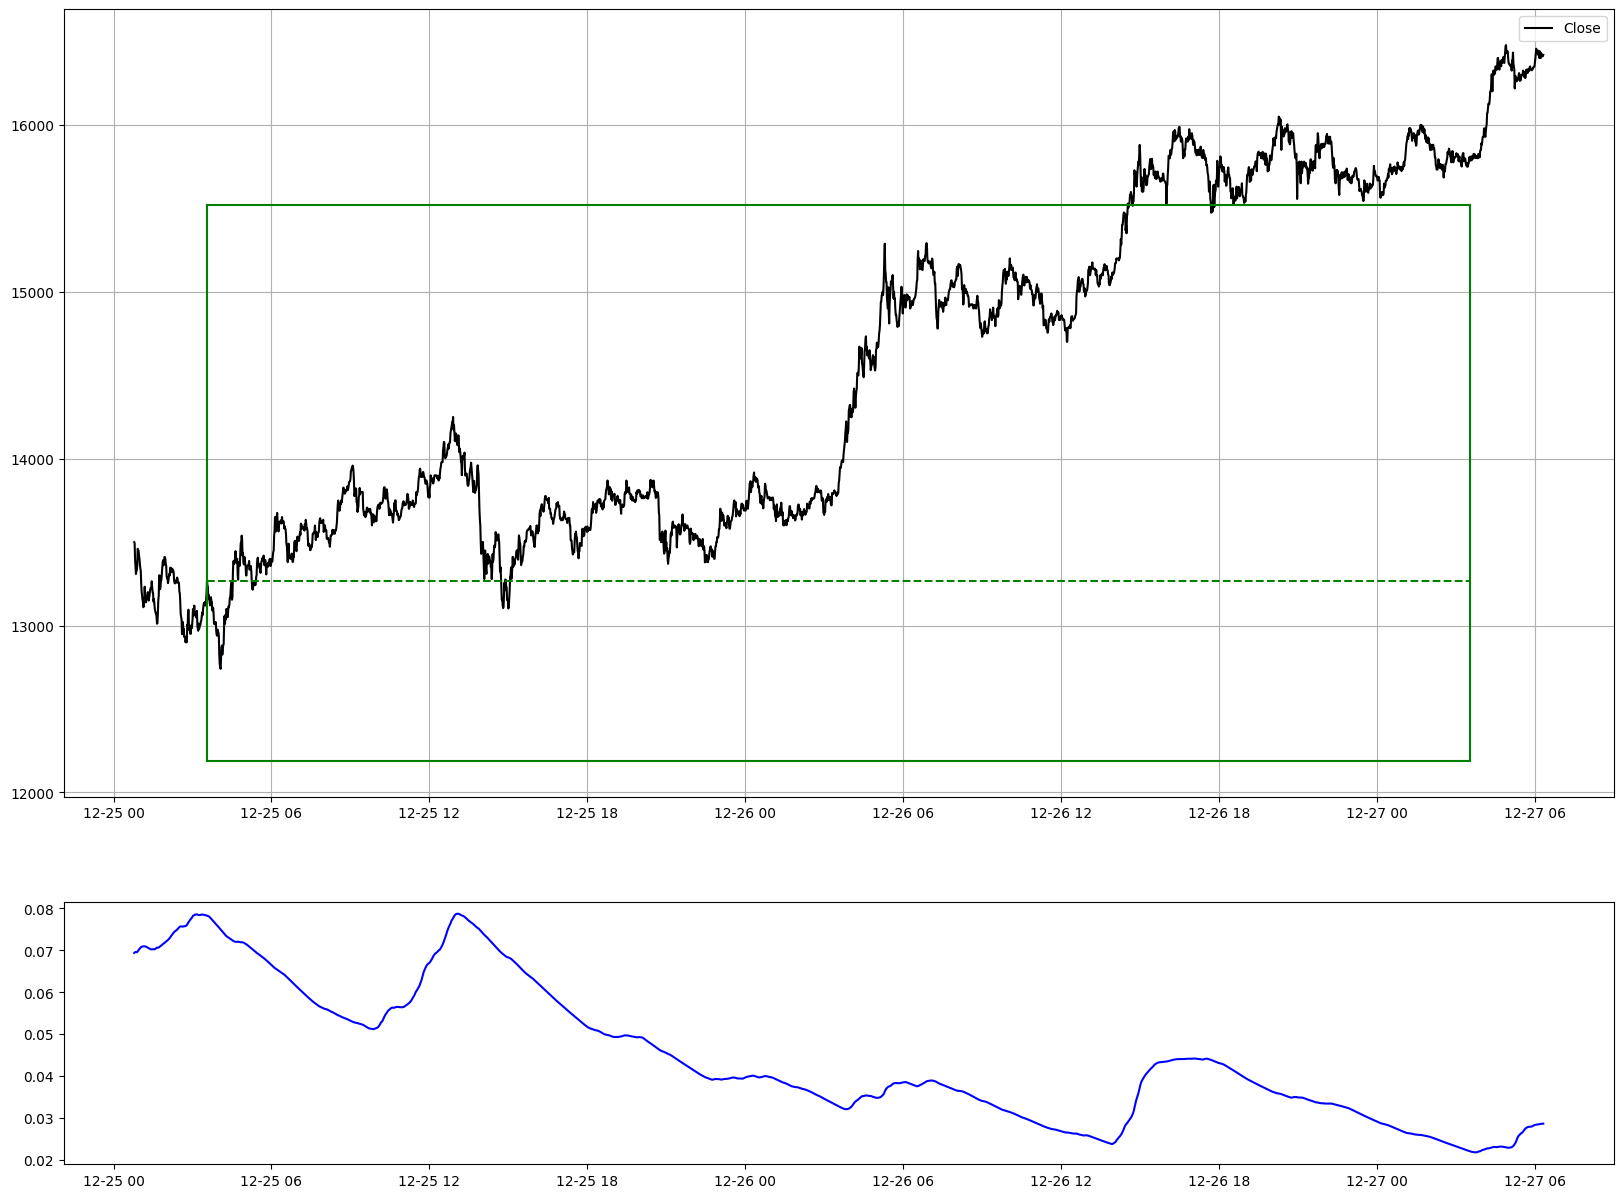

In [31]:
# Plotting buy side labels

f, axs = plt.subplots(2, gridspec_kw={'height_ratios': [3,1]}, figsize=(20,15))

label         = labels[(labels['bin']==1)&(labels['side']==1)].sample()
selected_date = label.index[0]

duration_seconds = 172800  # 2 days

frame_start   = selected_date - pd.Timedelta(seconds=10000) 
frame_end     = selected_date + pd.Timedelta(seconds=duration_seconds+10000)

df_ = df.loc[(df.index>=frame_start)&(df.index<=frame_end)]

event_start = selected_date
event_end   = selected_date+pd.Timedelta(seconds=duration_seconds)

close_price = df.loc[df.index==selected_date]['Close'].values[-1]

volatility_tpsl = round(df['volatility_tpsl_600'][selected_date], 6)

ret_upper = np.exp(round((volatility_tpsl*long_ptsl[0]), 6))-1.0
ret_lower = np.exp(round((volatility_tpsl*long_ptsl[1]), 6))-1.0

price_upper = (ret_upper+1.0)*close_price
price_lower = (ret_lower+1.0)*close_price

delta_upper = abs(close_price-price_upper)
delta_lower = abs(close_price-price_lower)

price_tp = close_price+delta_upper
price_sl = close_price-delta_lower


df_plot = df_

axs[0].plot(df_plot['Close'], color='k', label='Close')
axs[0].legend(loc='best')
axs[0].grid()

axs[0].plot([event_start, event_end  ], [price_tp    , price_tp  ], 'r-' , color='g')
axs[0].plot([event_start, event_end  ], [price_sl    , price_sl  ], 'r-' , color='g')
axs[0].plot([event_start, event_end  ], [close_price, close_price], 'r--', color='g')
axs[0].plot([event_start, event_start], [price_sl    , price_tp  ], 'r-' , color='g')
axs[0].plot([event_end  , event_end  ], [price_sl    , price_tp  ], 'r-' , color='g')

axs[1].plot(df_plot['volatility_tpsl_600'], color='b', label="daily volatility")

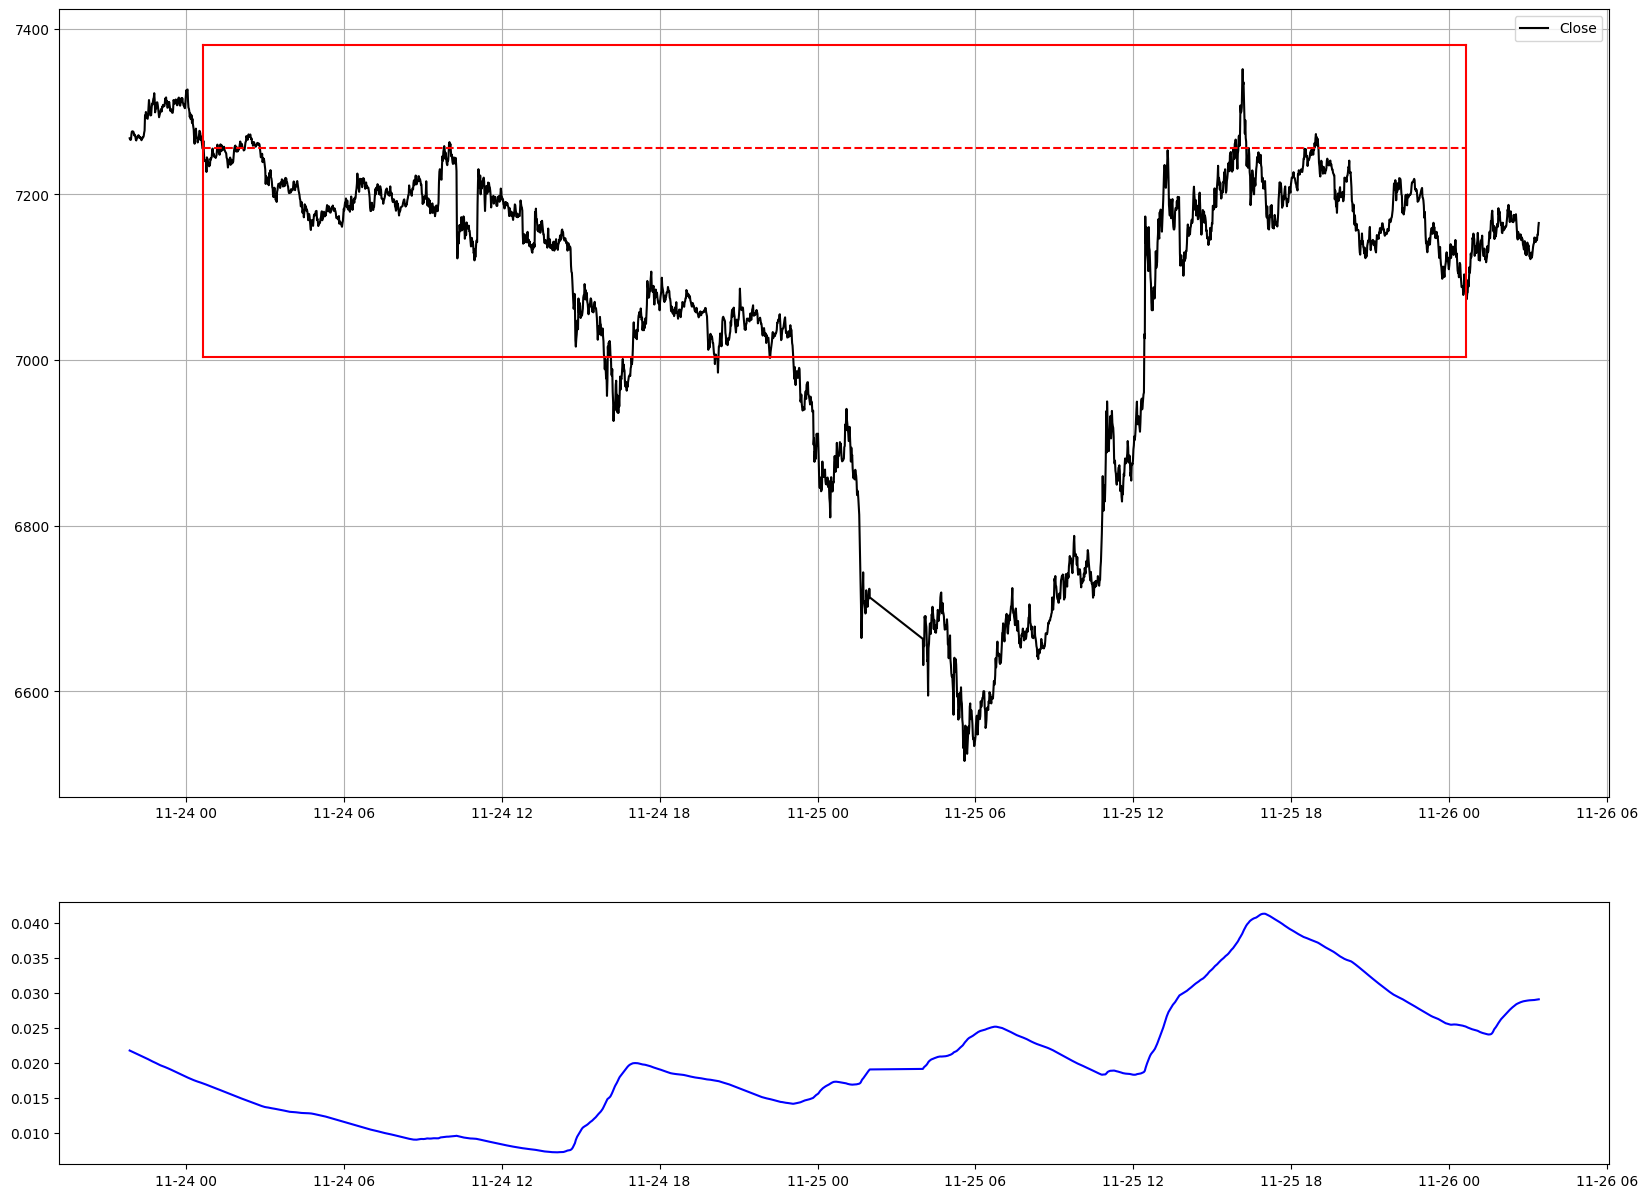

In [37]:
# Plotting sell side labels

f, axs = plt.subplots(2, gridspec_kw={'height_ratios': [3,1]}, figsize=(20,15))

label         = labels[(labels['bin']==1)&(labels['side']==-1)].sample()
selected_date = label.index[0]

duration_seconds = 172800 # 2 days

frame_start   = selected_date - pd.Timedelta(seconds=10000) 
frame_end     = selected_date + pd.Timedelta(seconds=duration_seconds+10000)

df_ = df.loc[(df.index>=frame_start)&(df.index<=frame_end)]

event_start = selected_date
event_end   = selected_date+pd.Timedelta(seconds=duration_seconds)

close_price = df.loc[df.index==selected_date]['Close'].values[-1]

volatility_tpsl = round(df['volatility_tpsl_600'][selected_date], 6)

ret_upper = np.exp(round((volatility_tpsl*short_ptsl[1]), 6))-1.0
ret_lower = np.exp(round((volatility_tpsl*short_ptsl[0]), 6))-1.0

price_upper = (ret_upper+1.0)*close_price
price_lower = (ret_lower+1.0)*close_price

delta_upper = abs(close_price-price_upper)
delta_lower = abs(close_price-price_lower)

price_sl = close_price+delta_upper
price_tp = close_price-delta_lower


df_plot = df_

axs[0].plot(df_plot['Close'], color='k', label='Close')
axs[0].legend(loc='best')
axs[0].grid()

axs[0].plot([event_start, event_end  ], [price_tp    , price_tp  ], 'r-' , color='r')
axs[0].plot([event_start, event_end  ], [price_sl    , price_sl  ], 'r-' , color='r')
axs[0].plot([event_start, event_end  ], [close_price, close_price], 'r--', color='r')
axs[0].plot([event_start, event_start], [price_sl    , price_tp  ], 'r-' , color='r')
axs[0].plot([event_end  , event_end  ], [price_sl    , price_tp  ], 'r-' , color='r')

axs[1].plot(df_plot['volatility_tpsl_600'], color='b', label="daily volatility")

In [38]:
trainable_features = [feature for feature in list(df.columns) if not feature in ["position", "Open", "High", "Low", "Close", "primary_side", "primary_prob", "is_signal"]]
print(trainable_features)

['Volume', 'volatility_tpsl_600', 'volatility_tpsl_840', 'sma_440', 'ma_440', 'daily_volatility_30', 'vm_eom_25', 'vl_atr_180', 'vm_cmf_180', 'vl_bbp', 't_adx_90', 'momentum_1', 'close_sign', 'close_plus_minus_40']


In [39]:
labels

,ret,trgt,bin,side
2017-08-18 04:46:00,-0.008146,0.004308,0,-1.0
2017-08-18 05:30:00,0.008246,0.004015,1,-1.0
2017-08-18 06:41:00,0.009732,0.004741,1,1.0
2017-08-18 06:45:00,-0.009638,0.005239,0,-1.0
2017-08-18 10:13:00,-0.009885,0.009921,0,-1.0
...,...,...,...,...
2022-12-23 14:36:00,-0.002777,0.002560,0,-1.0
2022-12-27 17:43:00,-0.002339,0.002192,0,1.0
2022-12-28 14:48:00,0.006851,0.002845,1,-1.0
2022-12-28 15:37:00,-0.008358,0.003811,0,1.0


In [40]:
meta_labels = labels.copy()
meta_labels['bin'] = labels['bin']
meta_labels['bin'].value_counts()

0    14841
1    11758
Name: bin, dtype: int64

In [41]:
meta_labels_train = meta_labels[:"2022-01-12"]
meta_labels_oos   = meta_labels["2022-01-14":]

In [42]:
# ML friendly dataset for meta labels

X_train = df.loc[meta_labels_train.index][trainable_features].copy()
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_train.fillna(0, inplace=True)
y_train = meta_labels_train['bin']

X_test  = df.loc[meta_labels_oos.index][trainable_features].copy()
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.fillna(0, inplace=True)
y_test  = meta_labels_oos['bin']

<AxesSubplot: >

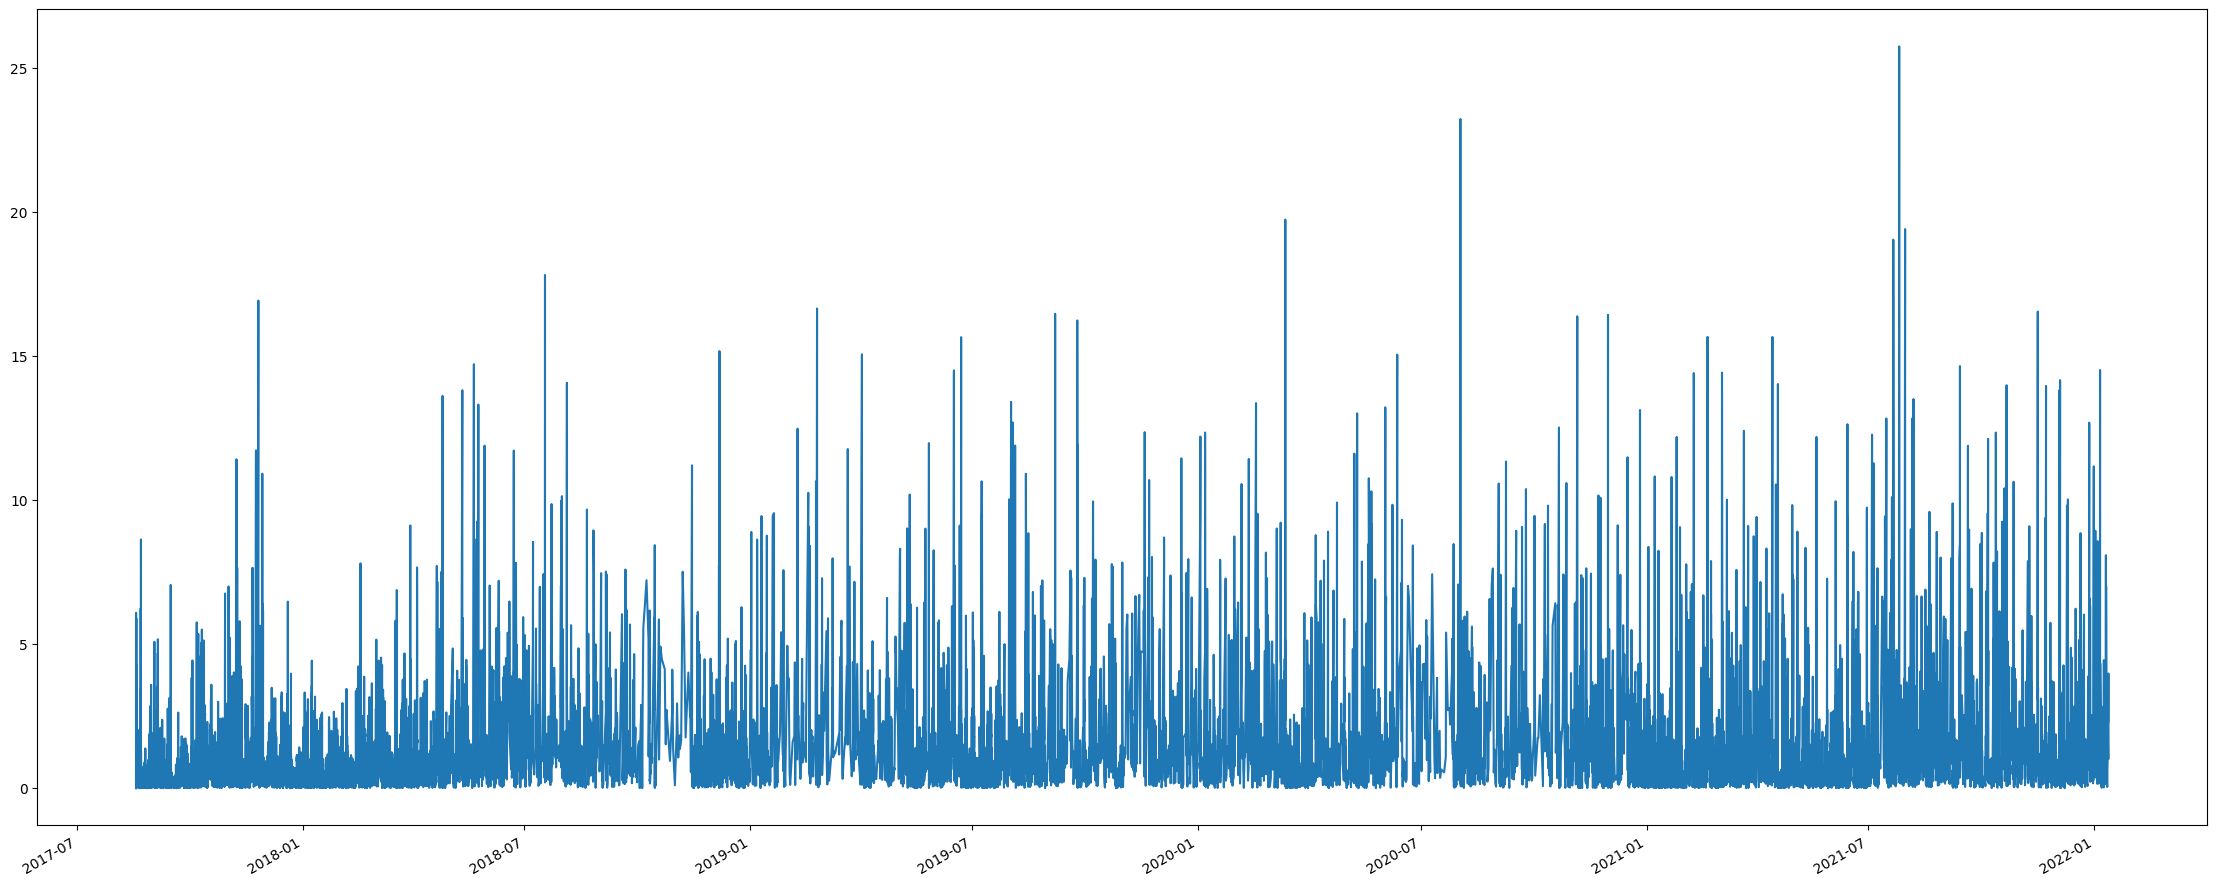

In [43]:
from mlfinlab.sample_weights import get_weights_by_return

return_based_sample_weights_meta = get_weights_by_return(
    triple_barrier_events.loc[X_train.index], 
    df.loc[X_train.index, 'Close'],
    num_threads=1)

_, axs = plt.subplots(1, figsize=(28,12))
return_based_sample_weights_meta.plot(ax=axs)

              precision    recall  f1-score   support

           0       0.67      0.41      0.51      1578
           1       0.34      0.60      0.43       801

    accuracy                           0.48      2379
   macro avg       0.51      0.51      0.47      2379
weighted avg       0.56      0.48      0.49      2379



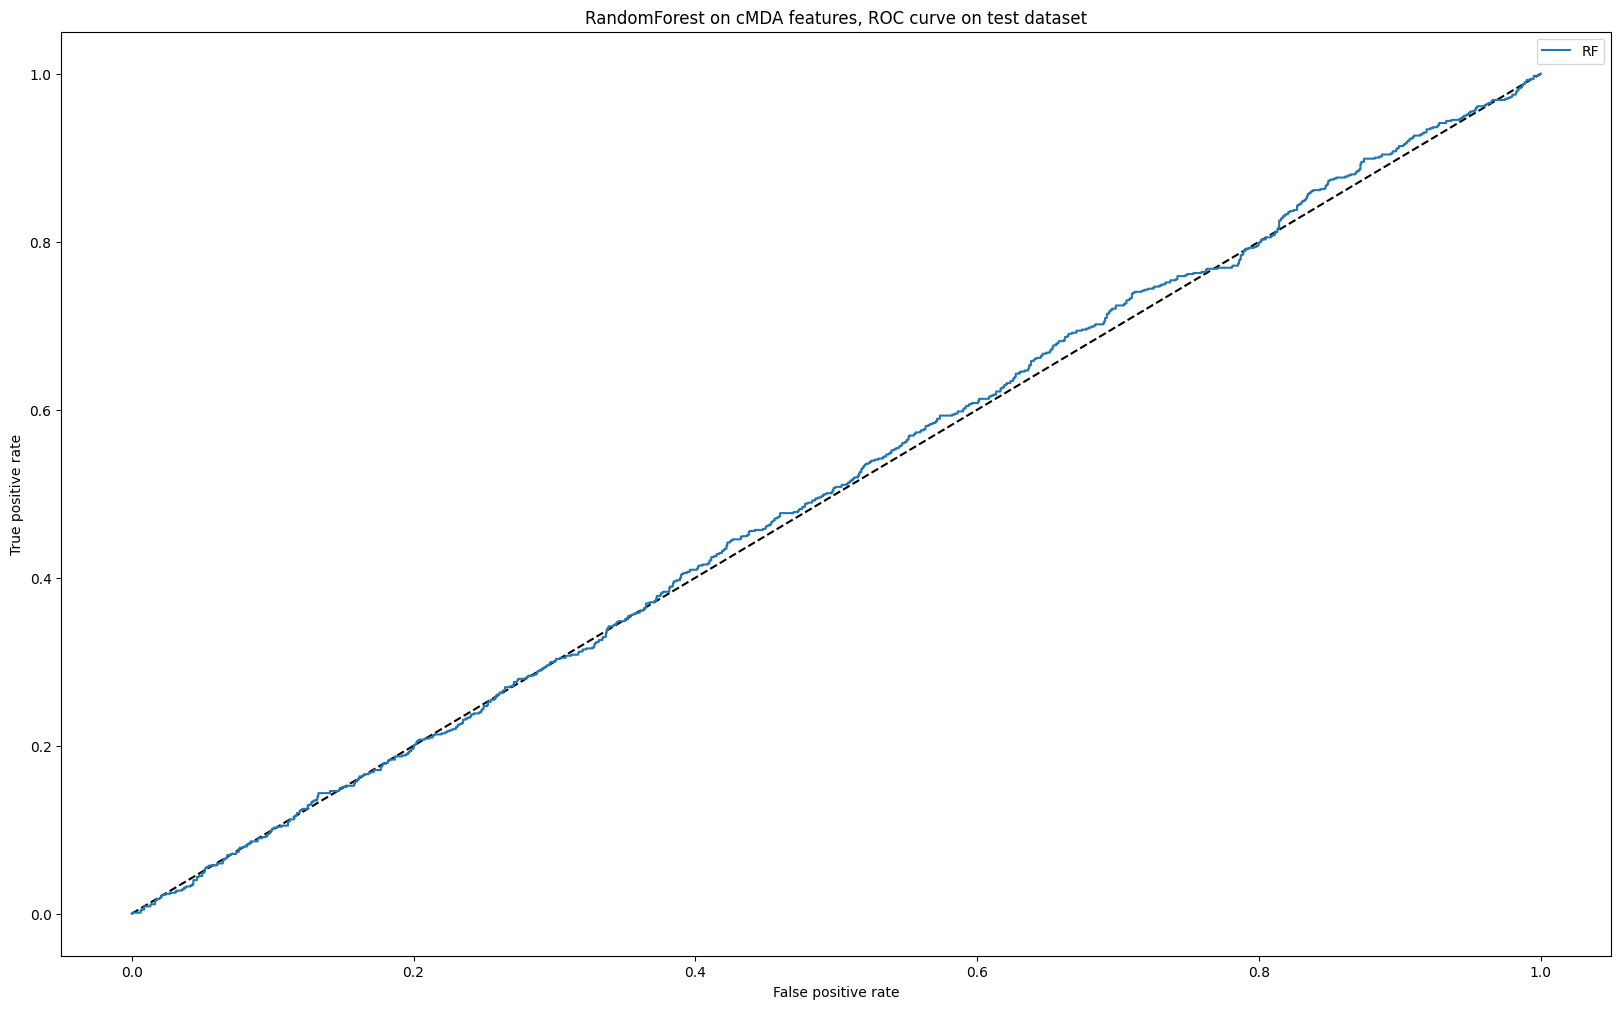

In [44]:
print(classification_report(
    y_test,
    meta_rf.predict(X_test[meta_features]),
    ))

fpr_rf, tpr_rf, _ = roc_curve(y_test, meta_rf.predict_proba(X_test[meta_features])[:, 1])
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('RandomForest on cMDA features, ROC curve on test dataset')
plt.legend(loc='best')
plt.show()

In [45]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

Text(0, 0.5, 'Count')

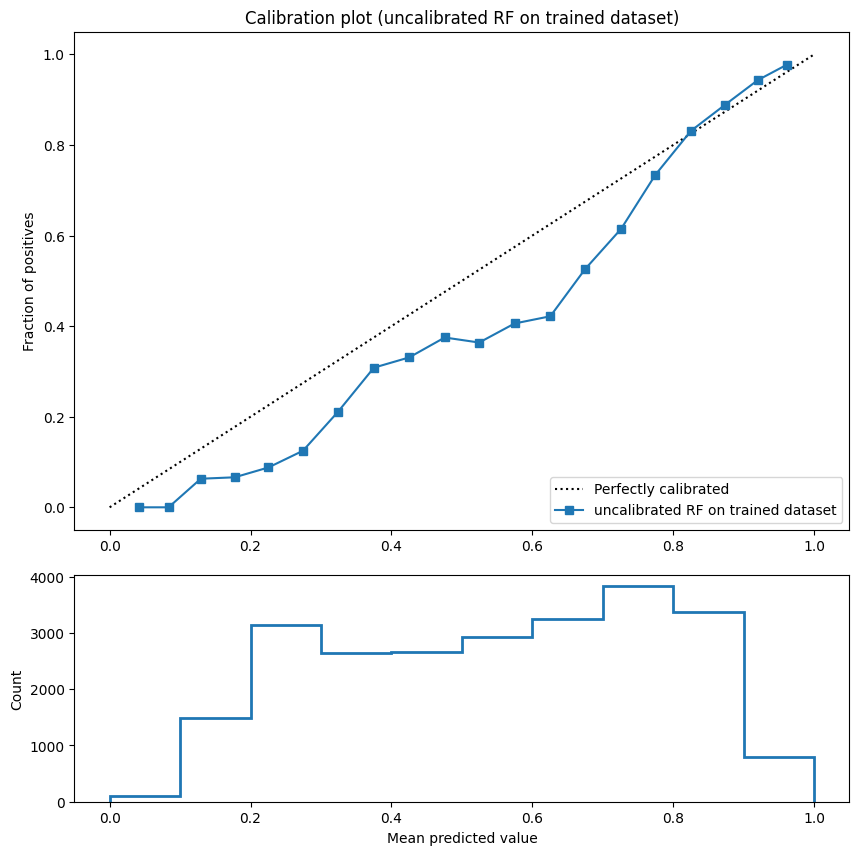

In [46]:
name = "uncalibrated RF on trained dataset"

probs = meta_rf.predict_proba(X_train[meta_features])[:,1]

fig = plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))
ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

frac_of_pos, mean_pred_value = calibration_curve(y_train, probs, n_bins=20)

ax1.plot(mean_pred_value, frac_of_pos, "s-", label=f'{name}')
ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title(f'Calibration plot ({name})')
ax2.hist(probs, range=(0, 1), bins=10, label=name, histtype="step", lw=2)
ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")

Text(0, 0.5, 'Count')

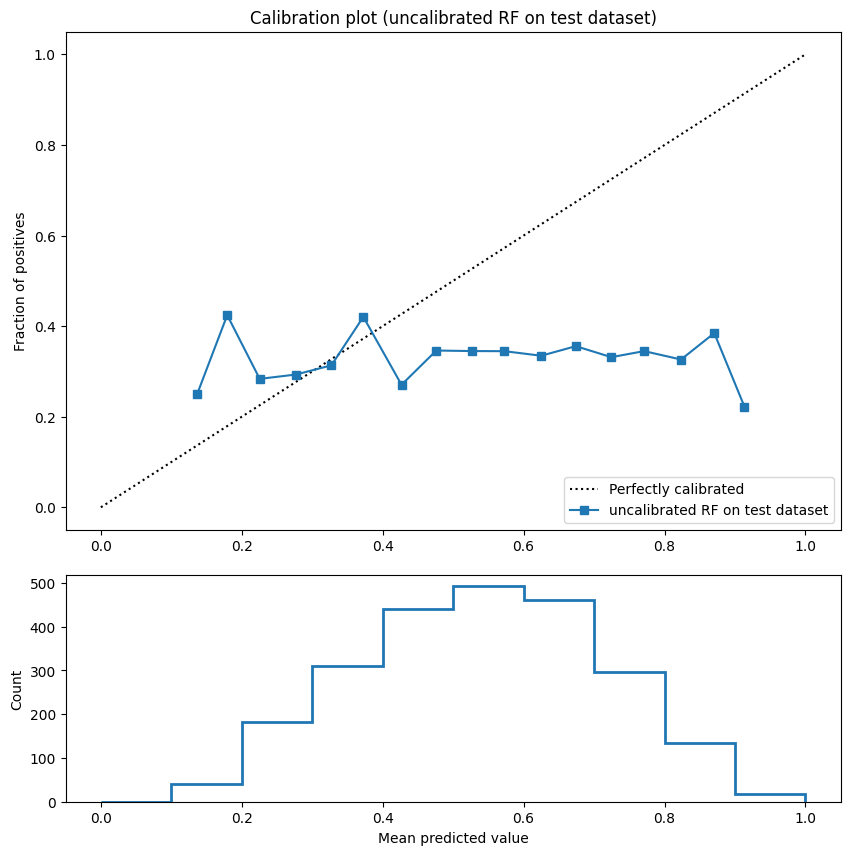

In [47]:
name = "uncalibrated RF on test dataset"

probs = meta_rf.predict_proba(X_test[meta_features])[:,1]

fig = plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))
ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

frac_of_pos, mean_pred_value = calibration_curve(y_test, probs, n_bins=20)

ax1.plot(mean_pred_value, frac_of_pos, "s-", label=f'{name}')
ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title(f'Calibration plot ({name})')
ax2.hist(probs, range=(0, 1), bins=10, label=name, histtype="step", lw=2)
ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")

In [48]:
eval_features = side_features+meta_features+['Open', 'High', 'Low', 'Close', 'Volume', 'volatility_tpsl_600']
eval_features = list(dict.fromkeys(eval_features))
eval_features

['ma_440',
 'daily_volatility_30',
 'vm_eom_25',
 'vl_atr_180',
 'vm_cmf_180',
 'vl_bbp',
 't_adx_90',
 'close_plus_minus_40',
 'Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'volatility_tpsl_600']

In [64]:
eval_df = df["2018-01-01":][eval_features].copy()
eval_df

,ma_440,daily_volatility_30,vm_eom_25,vl_atr_180,vm_cmf_180,vl_bbp,t_adx_90,close_plus_minus_40,Open,High,Low,Close,Volume,volatility_tpsl_600
timestamp,,,,,,,,,,,,,,
2018-01-01 00:00:00,-0.009802,0.009583,-2.555869e+10,39.248509,-0.053413,0.258123,12.045778,-6.0,13715.65,13715.65,13681.00,13707.92,2.844266,0.045871
2018-01-01 00:01:00,-0.010703,0.009931,-2.238221e+10,39.262739,-0.053496,0.151950,12.152555,-8.0,13707.91,13707.91,13666.11,13694.92,2.113138,0.045828
2018-01-01 00:02:00,-0.011730,0.010449,5.104236e+08,39.127613,-0.062850,0.054023,12.258146,-10.0,13682.00,13694.94,13680.00,13680.00,1.346411,0.045791
2018-01-01 00:03:00,-0.014138,0.010516,-3.201611e+10,39.349126,-0.056719,-0.132717,12.419381,-10.0,13679.98,13679.98,13601.00,13645.99,11.589417,0.045746
2018-01-01 00:04:00,-0.017406,0.010263,-1.301328e+10,39.517853,-0.071858,-0.242620,12.595290,-10.0,13645.98,13646.00,13576.28,13600.00,15.724566,0.045690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 23:55:00,-0.001543,0.000443,1.815970e+06,5.777728,0.025433,0.272406,14.161816,4.0,16540.42,16540.92,16537.71,16539.28,36.236830,0.003830
2022-12-31 23:56:00,-0.001460,0.000430,7.800272e+05,5.757574,0.026151,0.351183,14.078037,4.0,16538.65,16540.53,16538.38,16540.52,38.588400,0.003830
2022-12-31 23:57:00,-0.001618,0.000417,-1.651225e+07,5.757476,0.028138,0.223332,14.009032,2.0,16540.52,16540.79,16535.05,16537.78,53.359780,0.003831


In [65]:
eval_df['position'  ] = side_rf.predict(eval_df[side_features])
eval_df['short_prob'] = side_rf.predict_proba(eval_df[side_features])[:,0]
eval_df['long_prob' ] = side_rf.predict_proba(eval_df[side_features])[:,1]

In [66]:
eval_df['position'].value_counts()

-1.0    1318074
 1.0    1303381
Name: position, dtype: int64

<AxesSubplot: >

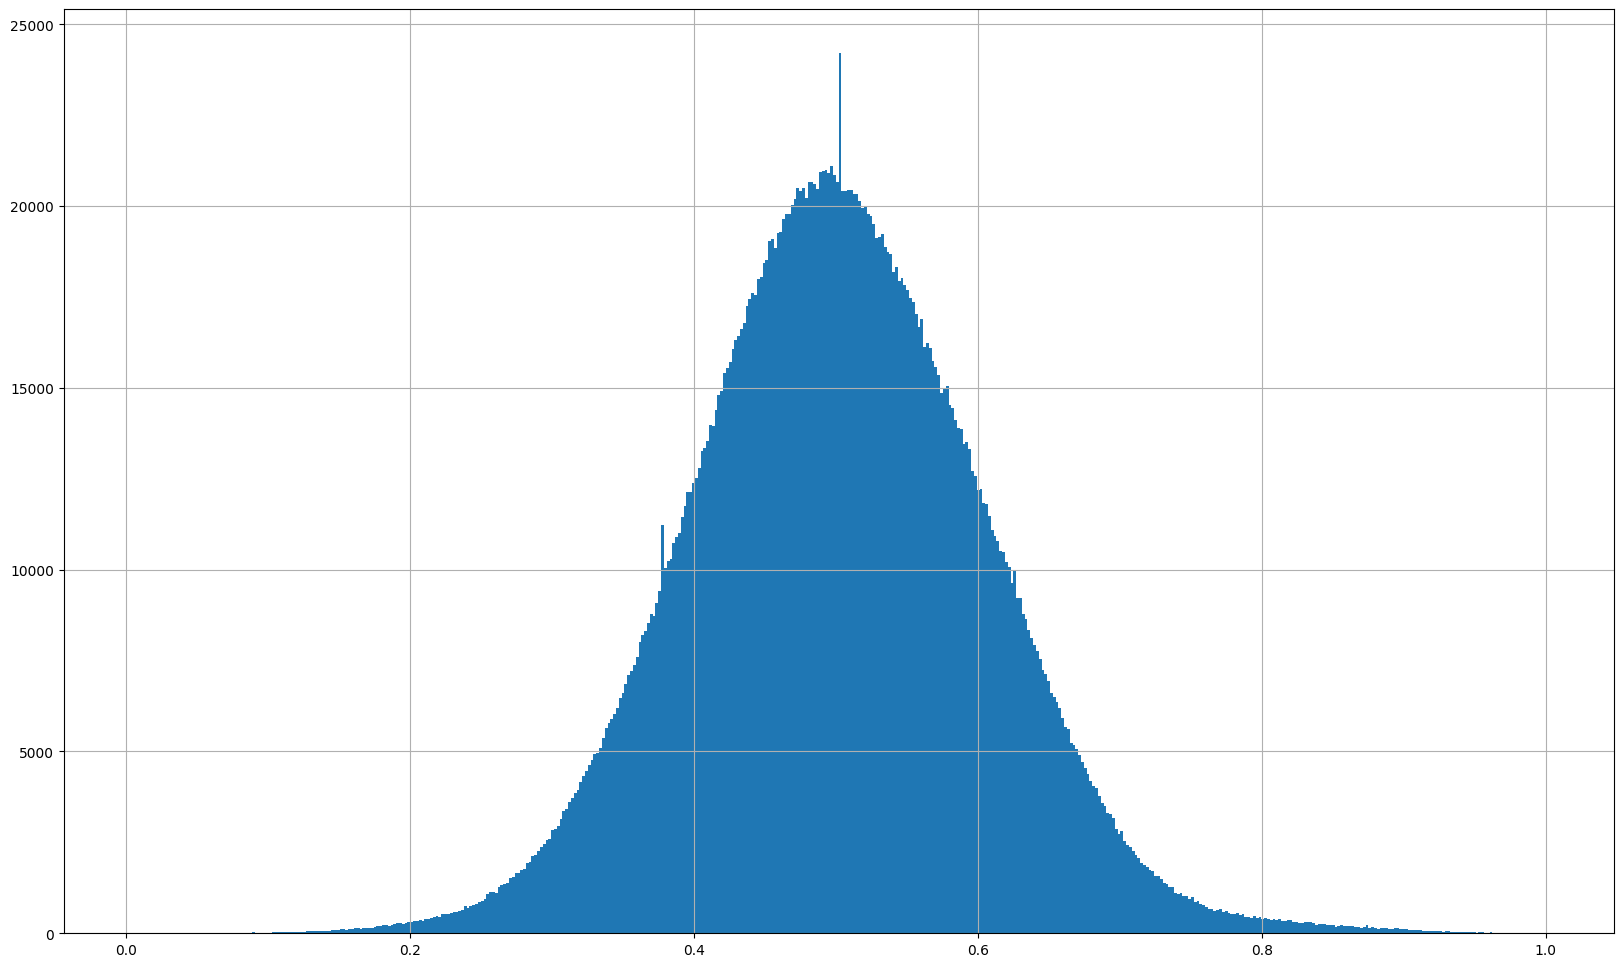

In [67]:
eval_df['long_prob'].hist(bins=500)

<AxesSubplot: >

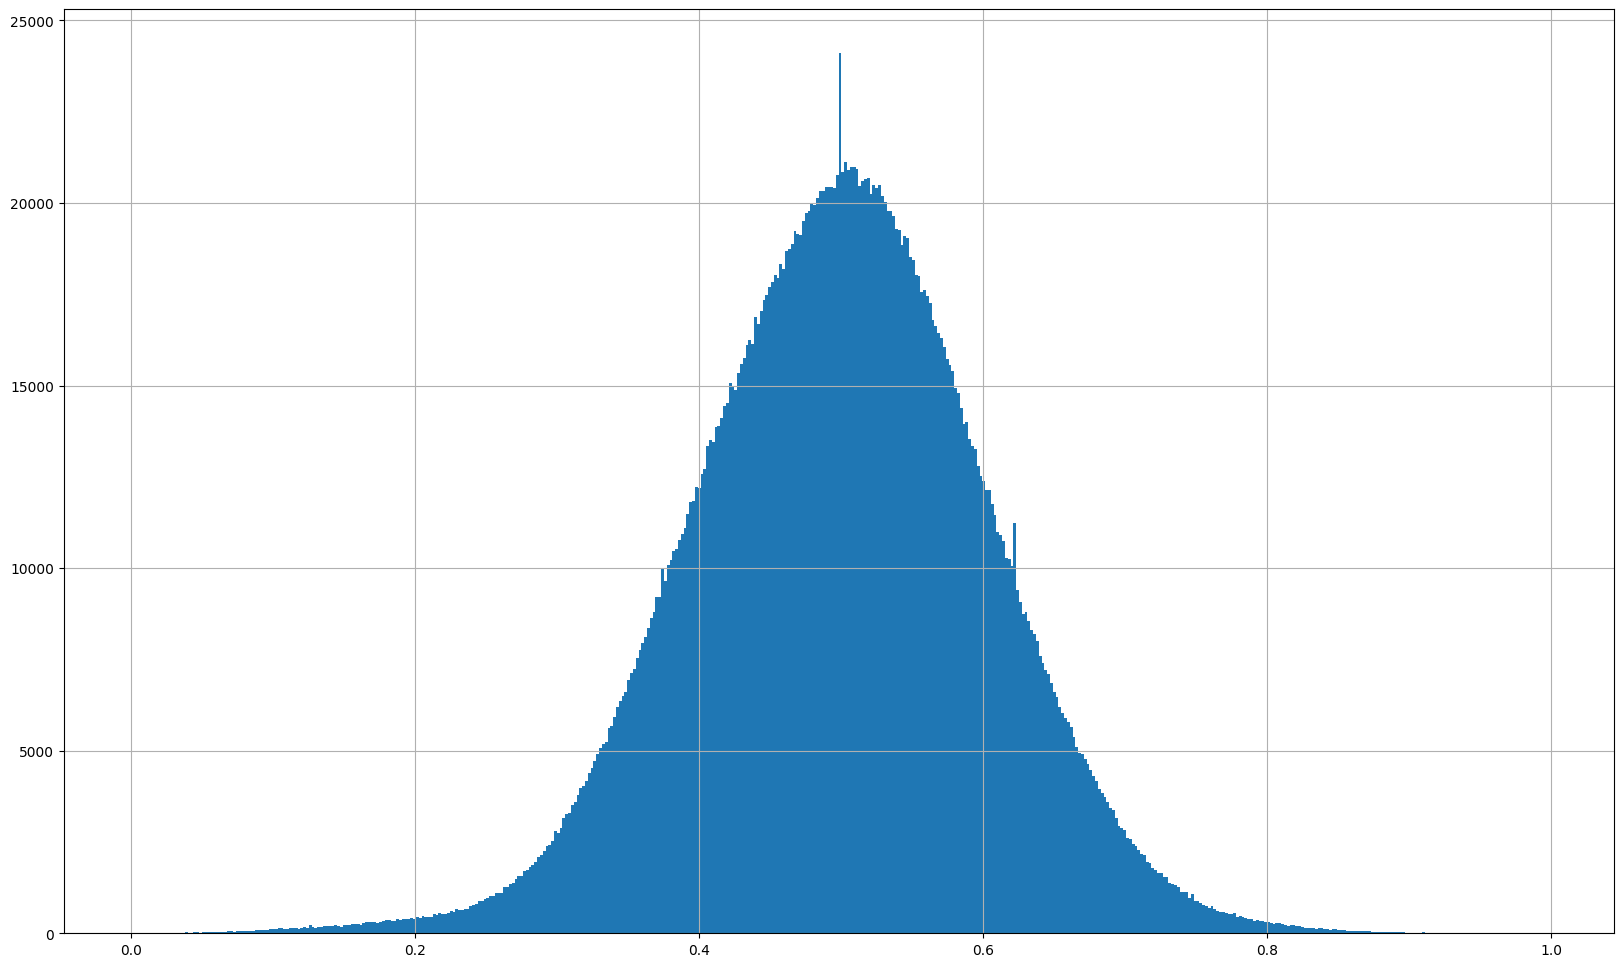

In [68]:
eval_df['short_prob'].hist(bins=500)

In [69]:
primary_threshold = 0.65

eval_df['is_signal'] = False
eval_df.loc[(eval_df['short_prob']>=primary_threshold)|(eval_df['long_prob']>=primary_threshold), 'is_signal'] = True

In [70]:
eval_df[eval_df['is_signal']==True]['position'].value_counts()

 1.0    189665
-1.0    177388
Name: position, dtype: int64

In [71]:
signal_indexes = eval_df[eval_df['is_signal']==True].index
eval_df['act'] = 0
eval_df.loc[signal_indexes, 'act'     ] = meta_rf.predict(eval_df.loc[signal_indexes][meta_features])
eval_df.loc[signal_indexes, 'act_prob'] = meta_rf.predict_proba(eval_df.loc[signal_indexes][meta_features])[:,1]

In [72]:
eval_df['act'].value_counts()

0    2406722
1     214733
Name: act, dtype: int64

<AxesSubplot: >

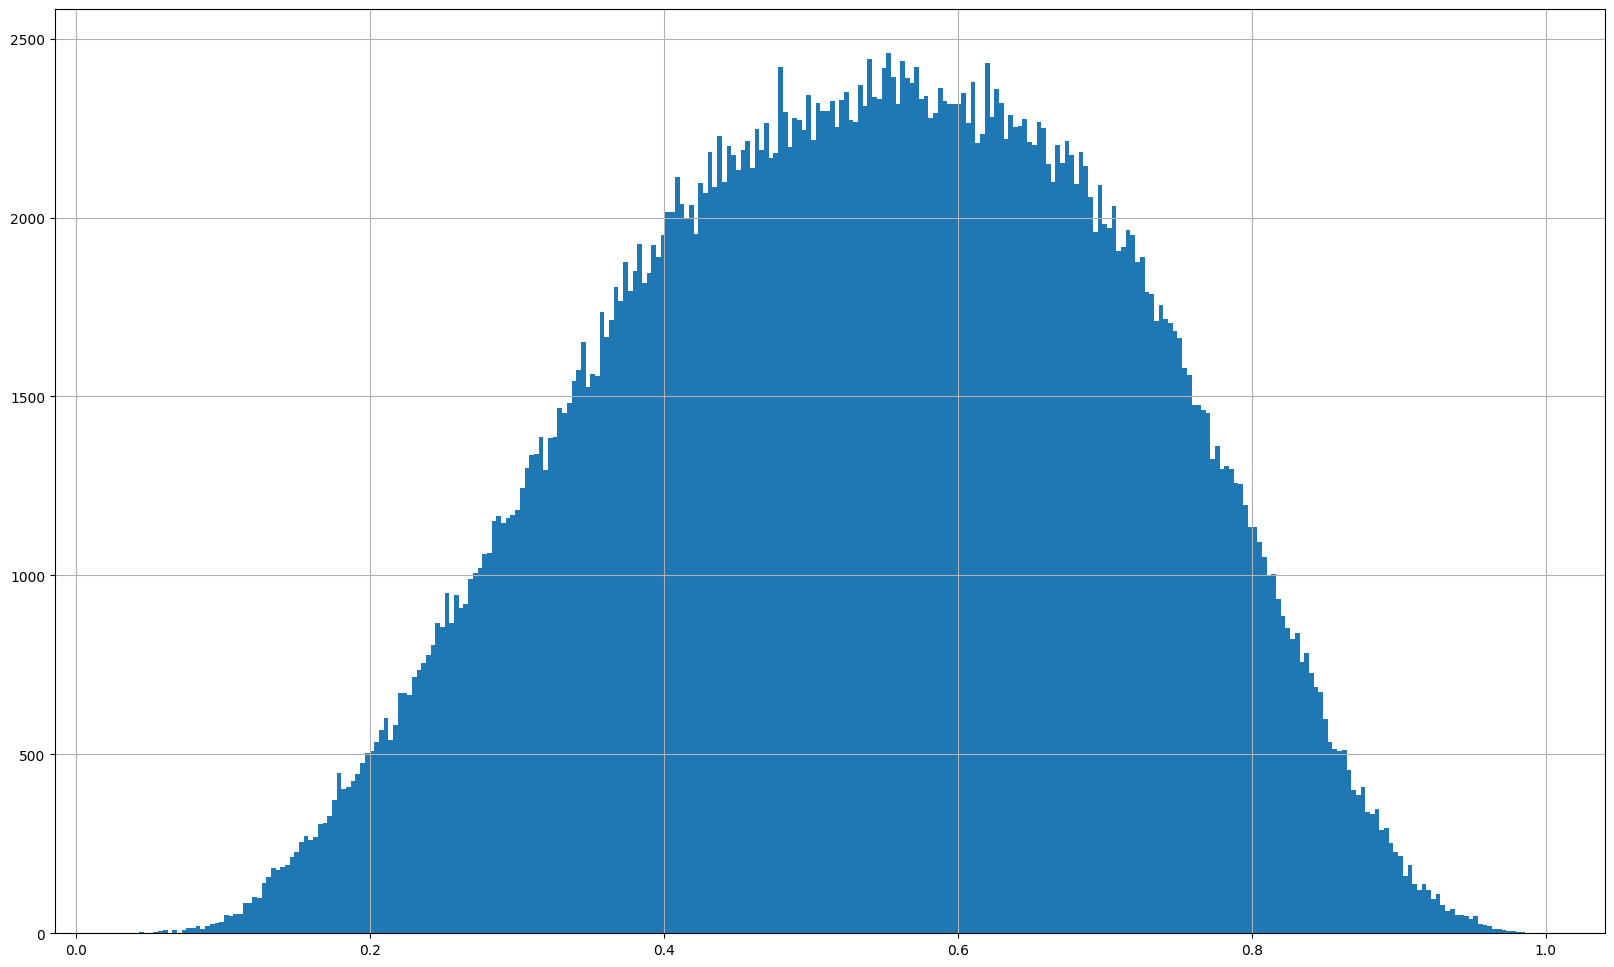

In [73]:
eval_df['act_prob'].hist(bins=300)

In [74]:
# Model performance evaluation on OOS data

from backtesting     import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.lib import resample_apply

def SMA(array, n):
    return pd.Series(array).rolling(n).mean()

def kelly(prob_win, payout_perc):
    return (prob_win * payout_perc - (1 - prob_win)) / payout_perc

binance_commission = 0.0004  # Taker Fee rate is 0.04%

In [75]:
act_threshold = 0.55

index_arr    = []
position_arr = []

class MetaStrategy(Strategy):
    def init(self):
        super().init()
    def next(self):
        super().next()

        available_to_trade = True
        if len(self.trades)>=1:
            available_to_trade = False
        if not available_to_trade:
            return

        event_dt        = self.data.index[-1]
        close_price     = self.data.Close[-1]
        volatility_tpsl = self.data.volatility_tpsl_600[-1]
        position        = self.data.position[-1]
        act_prob        = self.data.act_prob[-1]

        size=0.1

        if position==1 and act_prob>=act_threshold:
            #size = round(kelly(act_prob, 1.0),2)
            ret_upper = np.exp(round((volatility_tpsl*long_ptsl[0]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*long_ptsl[1]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_tp = close_price+delta_upper
            price_sl = close_price-delta_lower
            #print(f"BUY at {close_price} SL={price_sl} TP={price_tp}")
            self.buy(size=size, sl=price_sl, tp=price_tp)
            index_arr.append(event_dt)
            position_arr.append(1)

        if position==-1 and act_prob>=act_threshold:
            #size = round(kelly(act_prob, 1.0),2)
            ret_upper = np.exp(round((volatility_tpsl*short_ptsl[1]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*short_ptsl[0]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_sl = close_price+delta_upper
            price_tp = close_price-delta_lower
            #print(f"SELL at {close_price} SL={price_sl} TP={price_tp}")
            self.sell(size=size, sl=price_sl, tp=price_tp)
            index_arr.append(event_dt)
            position_arr.append(-1)

bt = Backtest(
    eval_df["2018-01-01":], 
    MetaStrategy, 
    cash             = 100000000, 
    commission       = binance_commission, 
    exclusive_orders = True
    )

stats = bt.run()
stats

Start                     2018-01-01 00:00:00
End                       2022-12-31 23:59:00
Duration                   1825 days 23:59:00
Exposure Time [%]                    96.55119
Equity Final [$]             719464768.334239
Equity Peak [$]              721682707.958474
Return [%]                         619.464768
Buy & Hold Return [%]               20.677681
Return (Ann.) [%]                   48.320132
Volatility (Ann.) [%]               14.566186
Sharpe Ratio                         3.317281
Sortino Ratio                       12.734793
Calmar Ratio                         10.75922
Max. Drawdown [%]                   -4.491044
Avg. Drawdown [%]                   -0.100224
Max. Drawdown Duration       86 days 20:15:00
Avg. Drawdown Duration        0 days 07:33:00
# Trades                                 4047
Win Rate [%]                        44.255004
Best Trade [%]                      23.112946
Worst Trade [%]                    -11.695872
Avg. Trade [%]                    

Start date,2018-01-01
End date,2022-12-31
Total months,192
,Backtest
Annual return,215.3%
Cumulative returns,10203945422.8%
Annual volatility,42.4%
Sharpe ratio,2.92
Calmar ratio,5.67
Stability,0.92
Max drawdown,-38.0%


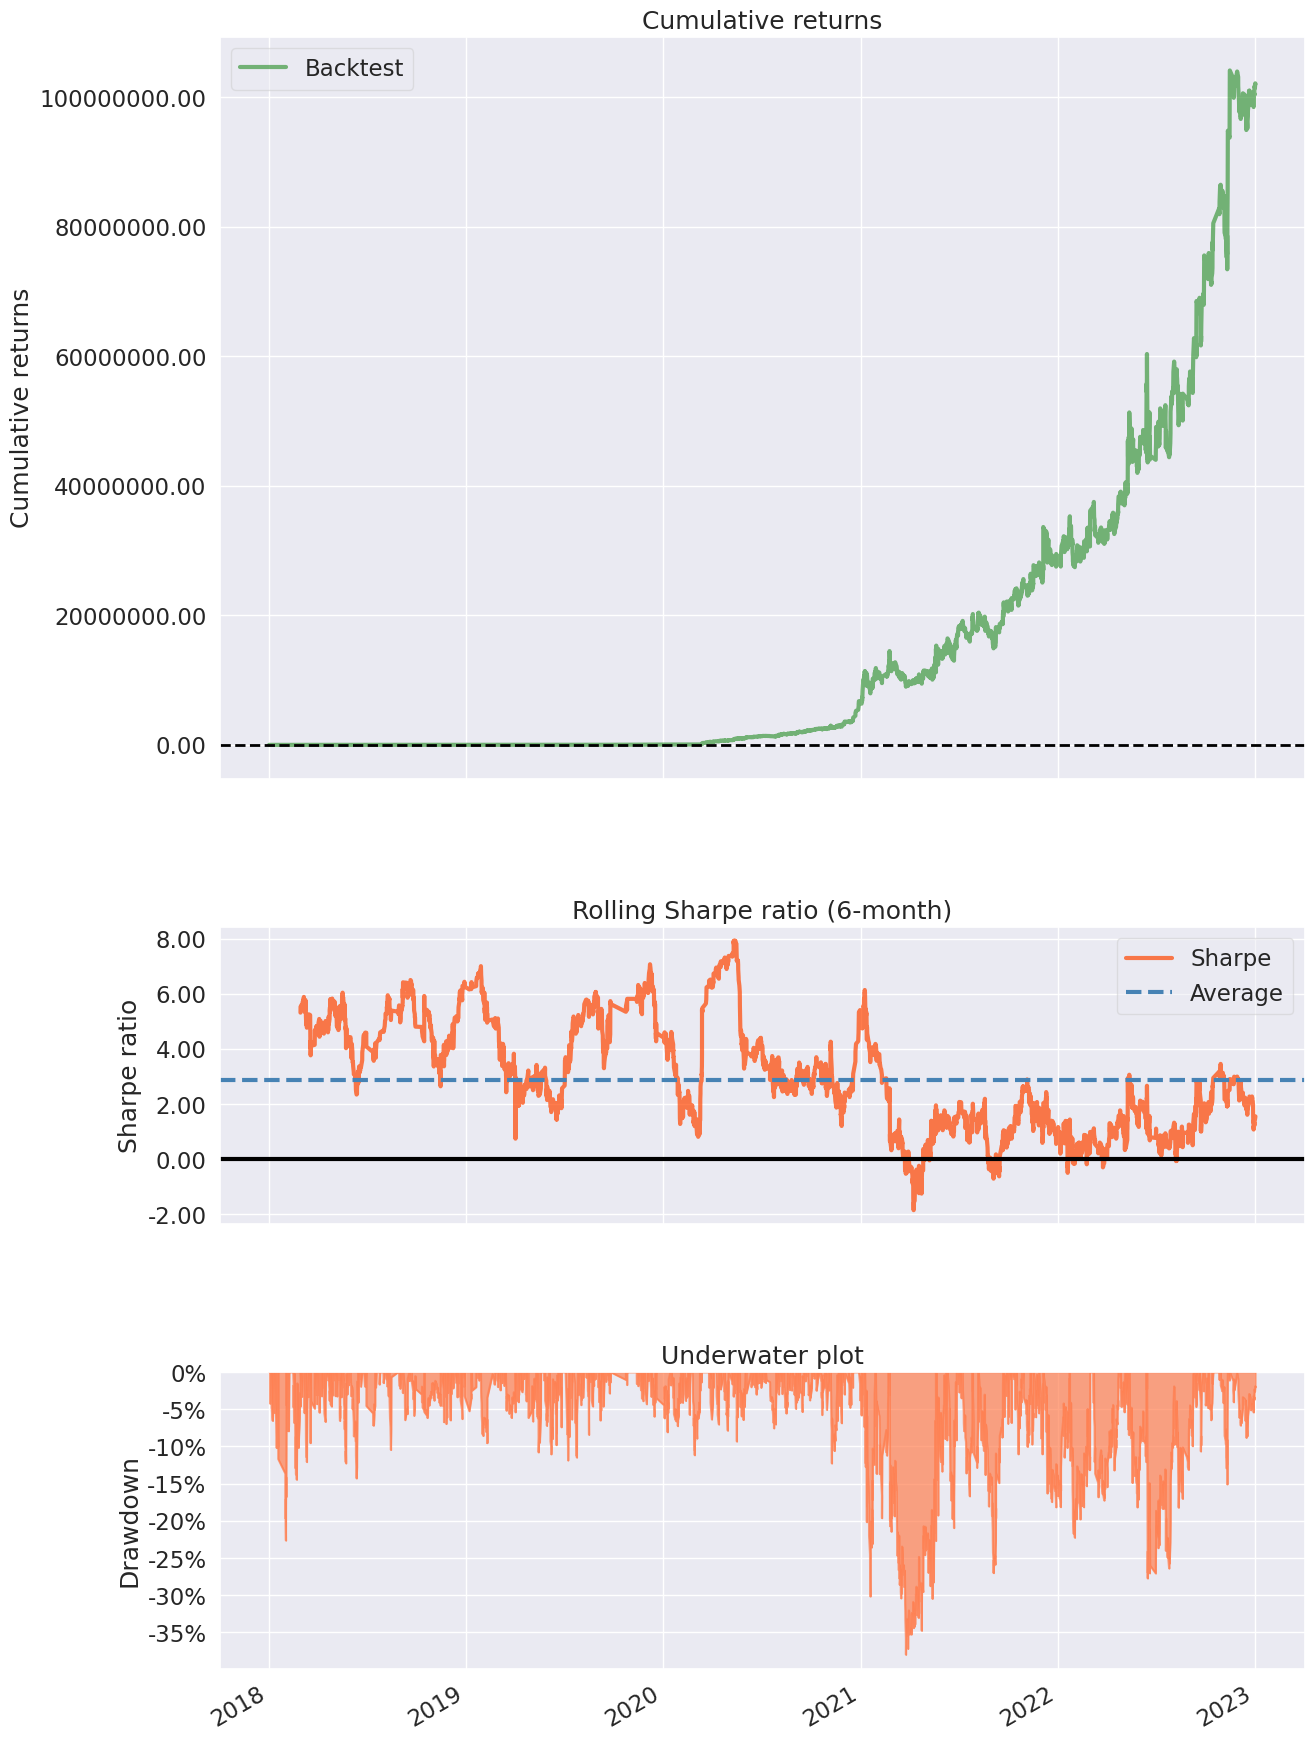

In [76]:
stats_df = stats['_trades'][['ReturnPct', 'EntryTime']]
stats_df = stats_df.set_index('EntryTime')

pf.create_simple_tear_sheet(stats_df['ReturnPct'])

In [77]:
len(index_arr), len(position_arr)

(4047, 4047)

In [78]:
signals_df = pd.DataFrame()
signals_df["timestamp"]= pd.DatetimeIndex(index_arr)
signals_df = signals_df.set_index('timestamp')
signals_df['position'] = position_arr

signals_df

,position
timestamp,
2018-01-01 00:06:00,-1
2018-01-02 18:24:00,1
2018-01-02 19:20:00,-1
2018-01-05 09:04:00,1
2018-01-05 17:26:00,1
...,...
2022-12-29 22:36:00,-1
2022-12-30 11:07:00,-1
2022-12-31 00:06:00,-1


In [79]:
signals_df.to_csv("../model/BTCUSDT-primary-signals.csv", header=True)

In [80]:
loaded_df = pd.read_csv("../model/BTCUSDT-primary-signals.csv", parse_dates=True, index_col="timestamp")
loaded_df

,position
timestamp,
2018-01-01 00:06:00,-1
2018-01-02 18:24:00,1
2018-01-02 19:20:00,-1
2018-01-05 09:04:00,1
2018-01-05 17:26:00,1
...,...
2022-12-29 22:36:00,-1
2022-12-30 11:07:00,-1
2022-12-31 00:06:00,-1
